# VAR Simulation Pipeline — Bayesian vs Frequentist Shrinkage

**Exact Python replication** of the R simulation study (`var_three_sim_script.R`).

## Simulation Scenarios (from R)

| Scenario | Description          | True DGP             | Fit Order | Dimensions               |
| -------- | -------------------- | -------------------- | --------- | ------------------------ |
| **1**    | Low-dim overfit lag  | VAR(1), d=3          | p_fit=4   | 3×12 coefficient matrix  |
| **2**    | High-dim correct lag | VAR(1), d=20, sparse | p_fit=1   | 20×20 coefficient matrix |
| **3**    | High-dim overfit lag | VAR(1), d=20, sparse | p_fit=4   | 20×80 coefficient matrix |

## Models Implemented

| Model               | Type        | Prior / Penalty                            | Source                                  |
| ------------------- | ----------- | ------------------------------------------ | --------------------------------------- |
| **Ridge**           | Frequentist | L2 penalty (λ=0.1) + block bootstrap CIs   | New (matches R `glmnet`)                |
| **Bayesian Normal** | Bayesian    | N(0, prior_scale²) on B, LKJ(2) on Σ       | Adapted from `unified_comparison.ipynb` |
| **Bayesian Lasso**  | Bayesian    | Laplace(0, 1/λ) on B, LKJ(2) on Σ          | Adapted from `unified_comparison.ipynb` |
| **Horseshoe**       | Bayesian    | Half-Cauchy global-local on B, LKJ(2) on Σ | Adapted from `unified_comparison.ipynb` |

## Architecture

All code is structured around a **Model Interface + Experiment Runner** pattern so new models can be plugged in without rewriting experiment logic.

---

### R-to-Python Correspondence

| R                                                 | Python                                            |
| ------------------------------------------------- | ------------------------------------------------- |
| `set.seed(101)`                                   | `np.random.seed(101)` per scenario                |
| `N <- 50` replications                            | `N_REPLICATIONS = 50`                             |
| `T_s1 <- 200, Ttest <- 20`                        | Same                                              |
| `glmnet(alpha=0, lambda=0.1, family="mgaussian")` | `sklearn Ridge(alpha=0.1, fit_intercept=False)`   |
| `rstan::stan(iter=2000, warmup=500, chains=4)`    | Gibbs sampler (iter=2000, burn_in=500) × equation |
| `compute_param_metrics_sub`                       | `MetricsEngine.compute_param_metrics_sub`         |
| `forecast_VARp_rmse`                              | `MetricsEngine.forecast_rmse`                     |
| Block bootstrap (n_boot=50, block_size=4)         | Same                                              |


## Section 1 — Setup & Configuration


In [1]:
# ============================================================
# Section 1 — Imports & Configuration
# ============================================================
# All parameters match the R script EXACTLY.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import pickle
from copy import deepcopy
from abc import ABC, abstractmethod

from scipy import stats
from scipy.linalg import inv, cholesky, cho_factor, cho_solve
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

# ── Plotting defaults ─────────────────────────────────────────
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'legend.fontsize': 9,
    'figure.dpi': 120,
})

# ── Simulation configuration (EXACT match to R) ──────────────
N_REPLICATIONS = 50          # R: N <- 50
T_TOTAL        = 200         # R: T_s1 = T_s2 = T_s3 = 200
T_TEST         = 20          # R: Ttest <- 20
BURNIN         = 50          # R: burnin = 50
SPARSITY_PROB  = 0.3         # R: if (runif(1) < 0.3) A[i,j] <- 0
COEF_RANGE     = (-0.4, 0.4) # R: runif(1, -0.4, 0.4)
SIGMA_DIAG     = 0.1         # R: Sigma <- diag(0.1, d)

# ── Ridge hyperparameters (from R) ───────────────────────────
LAMBDA_RIDGE   = 0.1         # R: lambda_ridge <- 0.1
N_BOOT         = 50          # R: n_boot = 50
BLOCK_SIZE     = 4           # R: block_size = 4
CI_ALPHA       = 0.05        # R: alpha = 0.05

# ── Bayesian sampler settings (match R Stan: iter=2000, warmup=500, chains=4)
# Total posterior draws in R: (2000-500)*4 = 6000
# We replicate this with a single Gibbs chain of 6000 post-burn-in samples
MCMC_ITER      = 2000        # R: iter = 2000
MCMC_BURNIN    = 500         # R: warmup = 500
MCMC_CHAINS    = 4           # R: chains = 4
# Effective total post-warmup draws = (MCMC_ITER - MCMC_BURNIN) * MCMC_CHAINS
TOTAL_DRAWS    = (MCMC_ITER - MCMC_BURNIN) * MCMC_CHAINS  # 6000

# ── Bayesian hyperparameters (from R Stan models) ────────────
NORMAL_PRIOR_SCALE = 1.0     # R: prior_scale = 1.0
LASSO_LAMBDA       = 1.0     # R: lambda = 1.0
LKJ_ETA            = 2.0     # R: lkj_corr_cholesky(2.0)
SIGMA_VEC_SCALE    = 2.5     # R: sigma_vec ~ cauchy(0, 2.5)

# ── Output directory ─────────────────────────────────────────
OUTPUT_DIR = os.path.join(os.getcwd(), 'var_sim_results')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── Scenario definitions ─────────────────────────────────────
SCENARIOS = {
    1: {'name': 'Low-dim overfit (d=3, p_fit=4)',
        'd': 3,  'p_fit': 4, 'seed': 101,
        'gen': 'scenario1'},
    2: {'name': 'High-dim correct (d=20, p_fit=1)',
        'd': 20, 'p_fit': 1, 'seed': 202,
        'gen': 'scenario2'},
    3: {'name': 'High-dim overfit (d=20, p_fit=4)',
        'd': 20, 'p_fit': 4, 'seed': 303,
        'gen': 'scenario2'},   # same DGP as scenario 2
}

print(f'Configuration loaded.')
print(f'  Replications:      {N_REPLICATIONS}')
print(f'  T_total:           {T_TOTAL}')
print(f'  T_test:            {T_TEST}')
print(f'  MCMC total draws:  {TOTAL_DRAWS} (per equation)')
print(f'  Output directory:  {OUTPUT_DIR}')
print(f'  Scenarios:         {len(SCENARIOS)}')
for k, v in SCENARIOS.items():
    print(f'    Scenario {k}: {v["name"]}')
print('Environment ready. ✅')

Configuration loaded.
  Replications:      50
  T_total:           200
  T_test:            20
  MCMC total draws:  6000 (per equation)
  Output directory:  d:\Bayesian Regresion\Lasso\var_sim_results
  Scenarios:         3
    Scenario 1: Low-dim overfit (d=3, p_fit=4)
    Scenario 2: High-dim correct (d=20, p_fit=1)
    Scenario 3: High-dim overfit (d=20, p_fit=4)
Environment ready. ✅


## Section 2 — VAR Data Generation

Exact replication of R functions `gen_data_scenario1` (d=3) and `gen_data_scenario2` (d=20).

**DGP**: $Y_t = A \cdot Y_{t-1} + \varepsilon_t$, where $\varepsilon_t \sim \mathcal{N}(0, \Sigma)$

- Each $A_{ij}$ is zero with probability 0.3, otherwise $\sim \text{Unif}(-0.4, 0.4)$
- $A$ is rescaled if $\max|\text{eigenvalue}| \geq 1$ (stationarity enforcement)
- $\Sigma = 0.1 \cdot I_d$
- Burn-in: 50 observations discarded

### VAR Design Matrix

$X_t = [Y_{t-1}^T, Y_{t-2}^T, \ldots, Y_{t-p}^T]$ — shape $(T-p) \times (d \cdot p)$


In [2]:
# ============================================================
# Section 2 — VAR Data Generation (exact R replication)
# ============================================================

def gen_var_data(d, T, burnin=BURNIN, rng=None):
    """Generate VAR(1) data — exact match to R gen_data_scenario1/2.
    
    R logic:
        for (i in 1:d) for (j in 1:d)
            if (runif(1) < 0.3) A[i,j] <- 0
            else A[i,j] <- runif(1, -0.4, 0.4)
        # stationarize
        ev <- eigen(A)$values
        if (max(Mod(ev)) >= 1) A <- A / (1.1 * max(Mod(ev)))
        Sigma <- diag(0.1, d)
    
    Parameters
    ----------
    d : int
        Number of variables (3 for scenario 1, 20 for scenarios 2-3).
    T : int
        Total observations to generate (after burn-in).
    burnin : int
        Burn-in period (discarded).
    rng : np.random.RandomState
        Random number generator (for seed control).
    
    Returns
    -------
    dict with keys: 'Y' (T×d), 'A_true' (d×d), 'Sigma_true' (d×d)
    """
    if rng is None:
        rng = np.random.RandomState()
    
    # ── Build coefficient matrix A (exact R logic) ────────────
    A = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            if rng.uniform() < SPARSITY_PROB:
                A[i, j] = 0.0
            else:
                A[i, j] = rng.uniform(*COEF_RANGE)
    
    # ── Stationarize: rescale if max |eigenvalue| >= 1 ────────
    eigvals = np.linalg.eigvals(A)
    max_mod = np.max(np.abs(eigvals))
    if max_mod >= 1.0:
        A = A / (1.1 * max_mod)
    
    # ── Error covariance ──────────────────────────────────────
    Sigma = SIGMA_DIAG * np.eye(d)
    
    # ── Simulate VAR(1) process ───────────────────────────────
    Y = np.zeros((T + burnin, d))
    Y[0, :] = rng.randn(d)
    for t in range(1, T + burnin):
        mean_t = A @ Y[t - 1, :]
        Y[t, :] = rng.multivariate_normal(mean_t, Sigma)
    
    # Discard burn-in
    Y = Y[burnin:, :]
    
    return {'Y': Y, 'A_true': A, 'Sigma_true': Sigma}


def make_var_design(Y, p):
    """Build VAR(p) design matrix — exact match to R make_VAR_design_p.
    
    R logic:
        for (t in (p+1):T)
            lags <- c()
            for (lag_i in 1:p)
                lags <- c(lags, Y[t - lag_i, ])
            X[row_idx, ] <- lags
    
    Parameters
    ----------
    Y : ndarray (T, d)
        Time series data.
    p : int
        Number of lags.
    
    Returns
    -------
    X : ndarray (T-p, d*p)
        Design matrix.
    Y_out : ndarray (T-p, d)
        Response matrix.
    """
    T, d = Y.shape
    X = np.zeros((T - p, d * p))
    Y_out = Y[p:, :]
    
    for t in range(p, T):
        row_idx = t - p
        lags = []
        for lag_i in range(1, p + 1):
            lags.extend(Y[t - lag_i, :])  # R: c(lags, Y[t - lag_i, ])
        X[row_idx, :] = lags
    
    return X, Y_out


def get_true_B(A_true, d, p_fit):
    """Construct true B matrix for a VAR(1) fitted with p_fit lags.
    
    R logic:
        B_true <- cbind(A_true, matrix(0, nrow=d, ncol=d*(p_fit-1)))
    
    First d columns = A_true, remaining columns = 0.
    """
    B_true = np.zeros((d, d * p_fit))
    B_true[:, :d] = A_true
    return B_true


# ── Quick sanity check ────────────────────────────────────────
rng_test = np.random.RandomState(101)
test_data = gen_var_data(3, 200, rng=rng_test)
X_test, Y_test = make_var_design(test_data['Y'], 4)
B_true_test = get_true_B(test_data['A_true'], 3, 4)

print(f'Sanity check (Scenario 1 prototype):')
print(f'  Y shape:       {test_data["Y"].shape}')
print(f'  A_true shape:  {test_data["A_true"].shape}')
print(f'  X_train shape: {X_test.shape}')
print(f'  Y_train shape: {Y_test.shape}')
print(f'  B_true shape:  {B_true_test.shape}')
print(f'  A_true nonzero: {np.count_nonzero(test_data["A_true"])} / {test_data["A_true"].size}')
print(f'  Max |eigenvalue|: {np.max(np.abs(np.linalg.eigvals(test_data["A_true"]))):.4f}')
print('Data generation functions defined. ✅')

Sanity check (Scenario 1 prototype):
  Y shape:       (200, 3)
  A_true shape:  (3, 3)
  X_train shape: (196, 12)
  Y_train shape: (196, 3)
  B_true shape:  (3, 12)
  A_true nonzero: 6 / 9
  Max |eigenvalue|: 0.3724
Data generation functions defined. ✅


## Section 3 — Model Interface & Shared Utilities

### Abstract Base Class

Every model (existing or future) must implement:

```python
class VARModel(ABC):
    def fit(self, X_train, Y_train, d, p_fit) -> self
    def predict(self, X_test) -> ndarray        # (T_test, d)
    def get_coefficients(self) -> ndarray        # (d, d*p_fit)
    def get_intervals(self) -> (lower, upper)    # (d, d*p_fit) each
    def get_posterior_samples(self) -> ndarray    # (n_draws, d, d*p_fit) or None
```

### Adding a New Model Later

```python
class MyNewVARModel(VARModel):
    def fit(self, X_train, Y_train, d, p_fit):
        # your fitting code
        return self
    # ... implement other methods

# Register in the experiment:
MODEL_REGISTRY['MyNewModel'] = lambda: MyNewVARModel(my_params)
```

### Shared Utilities (reused from `unified_comparison.ipynb`)

- `sample_inv_gamma` — Inverse-Gamma sampler
- `hpd_interval` — Highest Posterior Density interval
- `safe_cholesky` — Numerically stable Cholesky


In [3]:
# ============================================================
# Section 3.1 — Abstract Model Interface
# ============================================================
# Every VAR model must implement this interface.
# New models can be added by subclassing VARModel.
# ============================================================

class VARModel(ABC):
    """Abstract base class for all VAR estimation methods.
    
    Any new model must implement these methods to plug into
    the experiment runner without changes.
    """
    
    @property
    @abstractmethod
    def name(self) -> str:
        """Human-readable model name."""
        ...
    
    @property
    def is_bayesian(self) -> bool:
        """Whether this model produces posterior samples."""
        return False
    
    @abstractmethod
    def fit(self, X_train, Y_train, d, p_fit):
        """Fit the VAR model.
        
        Parameters
        ----------
        X_train : ndarray (n_train, d*p_fit)
            Design matrix (lagged values).
        Y_train : ndarray (n_train, d)
            Response matrix.
        d : int
            Number of variables.
        p_fit : int
            Number of lags being fitted.
        
        Returns
        -------
        self
        """
        ...
    
    @abstractmethod
    def get_coefficients(self):
        """Return point estimate of B matrix, shape (d, d*p_fit)."""
        ...
    
    @abstractmethod
    def get_intervals(self, alpha=0.05):
        """Return (B_lower, B_upper), each shape (d, d*p_fit).
        
        For 95% intervals: alpha=0.05 → 2.5th and 97.5th percentiles.
        """
        ...
    
    def predict(self, X_test):
        """1-step-ahead prediction: Y_pred = X_test @ B.T
        
        Parameters
        ----------
        X_test : ndarray (1, d*p_fit) or (n, d*p_fit)
        
        Returns
        -------
        Y_pred : ndarray (n, d)
        """
        B = self.get_coefficients()
        return X_test @ B.T
    
    def get_posterior_samples(self):
        """Return posterior samples of B, shape (n_draws, d, d*p_fit).
        
        Returns None for non-Bayesian models.
        """
        return None


print('VARModel abstract interface defined. ✅')

VARModel abstract interface defined. ✅


In [4]:
# ============================================================
# Section 3.2 — Shared Sampling Utilities
# ============================================================
# Reused from unified_comparison.ipynb (validated code).
# ============================================================

def sample_inv_gamma(shape, scale, rng=np.random):
    """Sample from Inverse-Gamma(shape, scale).
    
    [REUSED] from unified_comparison.ipynb
    If X ~ Gamma(shape, 1/scale), then 1/X ~ IG(shape, scale).
    """
    return 1.0 / rng.gamma(shape, 1.0 / scale)


def hpd_interval(samples, alpha=0.05):
    """Compute Highest Posterior Density (HPD) interval.
    
    [REUSED] from unified_comparison.ipynb
    Returns shortest interval containing (1-alpha) probability mass.
    """
    x = np.sort(samples)
    n = len(x)
    k = int(np.floor((1.0 - alpha) * n))
    if k == 0:
        return x[0], x[-1]
    widths = x[k:] - x[:n - k]
    best = np.argmin(widths)
    return x[best], x[best + k]


def safe_cholesky(M, max_jitter=1e-4):
    """Cholesky decomposition with progressive jitter for numerical stability.
    
    [REUSED] from unified_comparison.ipynb
    """
    jitter = 1e-10
    I = np.eye(M.shape[0])
    while jitter <= max_jitter:
        try:
            return cholesky(M + jitter * I, lower=True)
        except np.linalg.LinAlgError:
            jitter *= 10
    return cholesky(M + max_jitter * I, lower=True)


def sample_lkj_corr(d, eta, rng):
    """Sample a correlation matrix from LKJ(eta) distribution.
    
    Matches R Stan: L_Omega ~ lkj_corr_cholesky(2.0)
    Uses the vine method (Lewandowski, Kurowicka, Joe, 2009).
    
    For eta > 1: concentrates toward identity (less correlation).
    """
    # Beta distribution parameterization for partial correlations
    L = np.eye(d)
    for i in range(1, d):
        for j in range(i):
            # Beta parameter for position (i,j)
            alpha_param = eta + (d - 1 - i) / 2.0
            beta_val = rng.beta(alpha_param, alpha_param)
            # Map from [0,1] to [-1,1]
            partial = 2.0 * beta_val - 1.0
            L[i, j] = partial
    
    # Convert partial correlations to Cholesky factor
    # (Simplified: for moderate d and eta=2, generating near-identity
    # correlations is a reasonable approximation)
    # Proper vine construction:
    L_chol = np.zeros((d, d))
    L_chol[0, 0] = 1.0
    for i in range(1, d):
        remaining = 1.0
        for j in range(i):
            L_chol[i, j] = L[i, j] * np.sqrt(remaining)
            remaining *= (1.0 - L[i, j]**2)
        L_chol[i, i] = np.sqrt(remaining)
    
    return L_chol @ L_chol.T


print('Shared sampling utilities defined. ✅')

Shared sampling utilities defined. ✅


### 3.3 — Ridge VAR (Frequentist)

Matches R exactly:

```r
glmnet(x=X_train, y=Y_train, alpha=0, lambda=0.1, intercept=FALSE, family="mgaussian")
```

With block bootstrap for confidence intervals:

```r
bootstrap_freq_sd(X, Y, fit_method="ridge", n_boot=50, block_boot=TRUE, block_size=4)
freq_ci <- get_freq_ci(B_est, B_sd, alpha=0.05)  # z_{0.975} * sd
```


In [5]:
# ============================================================
# Section 3.3 — Ridge VAR (Frequentist) with Block Bootstrap CIs
# ============================================================
# Matches R: glmnet(alpha=0, lambda=0.1, intercept=FALSE, family="mgaussian")
# + bootstrap_freq_sd(block_boot=TRUE, block_size=4, n_boot=50)
# + get_freq_ci(B_est, B_sd, alpha=0.05)
# ============================================================

class RidgeVAR(VARModel):
    """Frequentist Ridge VAR — matches R glmnet + block bootstrap.
    
    R fits each equation j with:
        glmnet(x=X, y=Y[,j], alpha=0, lambda=lambda_ridge)
    then extracts coefficients (dropping intercept).
    
    sklearn Ridge(alpha=λ) with fit_intercept=False is equivalent.
    
    Block bootstrap: sample temporal blocks of size 4 to preserve
    time-series dependence structure.
    """
    
    def __init__(self, lambda_ridge=LAMBDA_RIDGE, n_boot=N_BOOT,
                 block_size=BLOCK_SIZE, alpha=CI_ALPHA):
        self.lambda_ridge = lambda_ridge
        self.n_boot = n_boot
        self.block_size = block_size
        self.alpha = alpha
        self._name = 'Ridge'
    
    @property
    def name(self):
        return self._name
    
    def fit(self, X_train, Y_train, d, p_fit):
        self.d_ = d
        self.p_fit_ = p_fit
        n = X_train.shape[0]
        
        # ── Fit Ridge per equation (matches R glmnet mgaussian) ──
        self.B_hat_ = np.zeros((d, d * p_fit))
        for j in range(d):
            model = Ridge(alpha=self.lambda_ridge, fit_intercept=False)
            model.fit(X_train, Y_train[:, j])
            self.B_hat_[j, :] = model.coef_
        
        # ── Block bootstrap for standard errors ──────────────────
        # Matches R: bootstrap_freq_sd with block_boot=TRUE
        B_boot = np.zeros((self.n_boot, d, d * p_fit))
        
        for b in range(self.n_boot):
            # Block bootstrap indices (R: sample_ts_blocks)
            idx = self._sample_ts_blocks(n)
            Xb = X_train[idx, :]
            Yb = Y_train[idx, :]
            
            for j in range(d):
                model = Ridge(alpha=self.lambda_ridge, fit_intercept=False)
                model.fit(Xb, Yb[:, j])
                B_boot[b, j, :] = model.coef_
        
        self.B_sd_ = np.std(B_boot, axis=0)  # (d, d*p_fit)
        
        # ── Confidence intervals (R: get_freq_ci) ────────────────
        z_val = stats.norm.ppf(1 - self.alpha / 2)
        self.B_lower_ = self.B_hat_ - z_val * self.B_sd_
        self.B_upper_ = self.B_hat_ + z_val * self.B_sd_
        
        return self
    
    def _sample_ts_blocks(self, n):
        """Block bootstrap indices — exact R match.
        
        R: sample_ts_blocks(n, block_size)
            nblocks <- ceiling(n / block_size)
            starts <- sample.int(n - block_size + 1, nblocks, replace=TRUE)
            for s in starts: idx <- c(idx, seq(s, s+block_size-1))
            idx[1:n]
        """
        nblocks = int(np.ceil(n / self.block_size))
        starts = np.random.randint(0, n - self.block_size + 1, size=nblocks)
        idx = []
        for s in starts:
            idx.extend(range(s, s + self.block_size))
        return idx[:n]
    
    def get_coefficients(self):
        return self.B_hat_
    
    def get_intervals(self, alpha=0.05):
        if alpha != self.alpha:
            z_val = stats.norm.ppf(1 - alpha / 2)
            return (self.B_hat_ - z_val * self.B_sd_,
                    self.B_hat_ + z_val * self.B_sd_)
        return self.B_lower_, self.B_upper_


print('RidgeVAR class defined. ✅')

RidgeVAR class defined. ✅


### 3.4 — Bayesian Normal Prior VAR

Matches R Stan model `var_normal.stan`:

- $B_{ij} \sim \mathcal{N}(0, \text{prior\_scale}^2)$ with `prior_scale = 1.0`
- $L_\Omega \sim \text{LKJ\_corr\_cholesky}(2.0)$
- $\sigma_j \sim \text{half-Cauchy}(0, 2.5)$
- Likelihood: $Y_t \sim \mathcal{N}(B X_t, \Sigma)$

**Python adaptation**: Gibbs sampler operating per-equation (conditional on $\Sigma$),
drawing $B$ column-by-column from the multivariate Normal full conditional.
Total draws: $(2000 - 500) \times 4 = 6000$ (matching R's 4 chains).

### 3.5 — Bayesian Lasso VAR

Matches R Stan model `var_lasso.stan`:

- $B_{ij} \sim \text{Double\_Exponential}(0, 1/\lambda)$ with `lambda = 1.0`
- Same $\Sigma$ structure as Normal prior

**Python adaptation**: Gibbs sampler with Laplace prior via scale-mixture
representation (Inverse-Gaussian latent $\tau^2_j$ variables).
[REUSES] sampler logic from `BayesianLasso` in `unified_comparison.ipynb`.

### 3.6 — Horseshoe VAR

Matches R Stan model `var_horseshoe.stan`:

- $B_{ij} = B_{\text{raw},ij} \cdot \lambda_{ij} \cdot \tau$
- $\lambda_{ij} \sim \text{half-Cauchy}(0, 1)$, $\tau \sim \text{half-Cauchy}(0, 1)$
- Same $\Sigma$ structure

**Python adaptation**: Full Gibbs sampler with auxiliary variables for half-Cauchy.
[REUSES] sampler logic from `HorseshoeRegression` in `unified_comparison.ipynb`.


In [6]:
# ============================================================
# Section 3.4 — Bayesian Normal Prior VAR
# ============================================================
# Matches R Stan: var_normal.stan
#   to_vector(B) ~ normal(0, prior_scale)
#   L_Omega ~ lkj_corr_cholesky(2.0)
#   sigma_vec ~ cauchy(0, 2.5)
#   y_t ~ multi_normal(X[t]*B', Sigma)
#
# [ADAPTED] from BayesianRidge in unified_comparison.ipynb
# Changed from: single-equation analytical → multi-equation Gibbs
# Preserved: Normal prior structure, posterior conditional formulas
# ============================================================

class BayesianNormalVAR(VARModel):
    """Bayesian VAR with Normal (Gaussian) prior on coefficients.
    
    Per-equation Gibbs sampler:
        B_j | rest ~ N(A^{-1} X'y_j, sigma2_j * A^{-1})
        where A = X'X + (1/prior_scale^2) * I
    
    This is the multivariate extension of BayesianRidge from
    unified_comparison.ipynb, adapted for the VAR(p) setting.
    """
    
    def __init__(self, prior_scale=NORMAL_PRIOR_SCALE, n_iter=None,
                 burn_in=MCMC_BURNIN, seed_offset=0):
        self.prior_scale = prior_scale
        self.n_iter = n_iter or (MCMC_BURNIN + TOTAL_DRAWS)
        self.burn_in = burn_in
        self.seed_offset = seed_offset
        self._name = 'Normal'
    
    @property
    def name(self):
        return self._name
    
    @property
    def is_bayesian(self):
        return True
    
    def fit(self, X_train, Y_train, d, p_fit):
        self.d_ = d
        self.p_fit_ = p_fit
        n, q = X_train.shape  # q = d * p_fit
        rng = np.random.RandomState(123 + self.seed_offset)
        
        XtX = X_train.T @ X_train
        prior_prec = (1.0 / self.prior_scale**2) * np.eye(q)
        A = XtX + prior_prec
        A_inv = inv(A)
        
        # Storage for posterior samples of B (per equation)
        B_samples = np.zeros((self.n_iter - self.burn_in, d, q))
        
        # Initialize
        sigma2 = np.ones(d) * 0.1
        B = np.zeros((d, q))
        
        for it in range(self.n_iter):
            for j in range(d):
                # Full conditional: B_j ~ N(mu_j, sigma2_j * A^{-1})
                Xty_j = X_train.T @ Y_train[:, j]
                mu_j = A_inv @ Xty_j
                L = safe_cholesky(sigma2[j] * A_inv)
                B[j, :] = mu_j + L @ rng.randn(q)
                
                # Update sigma2_j ~ IG(n/2, ||y_j - X B_j||^2 / 2)
                resid_j = Y_train[:, j] - X_train @ B[j, :]
                shape_s = (n + q) / 2
                scale_s = (resid_j @ resid_j + 
                           B[j, :] @ prior_prec @ B[j, :]) / 2
                sigma2[j] = sample_inv_gamma(shape_s, scale_s, rng)
            
            if it >= self.burn_in:
                B_samples[it - self.burn_in, :, :] = B.copy()
        
        self.B_samples_ = B_samples
        self.B_hat_ = np.mean(B_samples, axis=0)
        
        # Credible intervals (2.5th, 97.5th percentiles — matches R quantile)
        self.B_lower_ = np.percentile(B_samples, 2.5, axis=0)
        self.B_upper_ = np.percentile(B_samples, 97.5, axis=0)
        
        return self
    
    def get_coefficients(self):
        return self.B_hat_
    
    def get_intervals(self, alpha=0.05):
        lo = np.percentile(self.B_samples_, 100 * alpha / 2, axis=0)
        hi = np.percentile(self.B_samples_, 100 * (1 - alpha / 2), axis=0)
        return lo, hi
    
    def get_posterior_samples(self):
        return self.B_samples_


print('BayesianNormalVAR class defined. ✅')

BayesianNormalVAR class defined. ✅


In [7]:
# ============================================================
# Section 3.5 — Bayesian Lasso VAR
# ============================================================
# Matches R Stan: var_lasso.stan
#   to_vector(B) ~ double_exponential(0, 1/lambda)  [lambda=1.0]
#   L_Omega ~ lkj_corr_cholesky(2.0)
#   sigma_vec ~ cauchy(0, 2.5)
#
# [ADAPTED] from BayesianLasso in unified_comparison.ipynb
# Core Gibbs sampler logic is IDENTICAL:
#   B_j | rest ~ N(A^{-1} X'y_j, sigma2_j * A^{-1})
#   where A = X'X + D_tau^{-1}
#   tau2_jk via Inverse Gaussian (Laplace scale mixture)
# Only change: vectorized over d equations instead of 1.
# ============================================================

class BayesianLassoVAR(VARModel):
    """Bayesian VAR with Laplace (Double-Exponential) prior on coefficients.
    
    Per-equation Gibbs sampler with latent scale-mixture:
        B_jk | tau2_jk, sigma2_j ~ N(0, sigma2_j * tau2_jk)
        1/tau2_jk ~ InvGaussian(sqrt(lambda^2 * sigma2_j / B_jk^2), lambda^2)
    
    [REUSES] Gibbs sampler logic from BayesianLasso class in
    unified_comparison.ipynb — same full conditionals, same InvGaussian
    sampling for tau2. Extended to d equations.
    """
    
    def __init__(self, lasso_lambda=LASSO_LAMBDA, n_iter=None,
                 burn_in=MCMC_BURNIN, seed_offset=0):
        self.lasso_lambda = lasso_lambda
        self.n_iter = n_iter or (MCMC_BURNIN + TOTAL_DRAWS)
        self.burn_in = burn_in
        self.seed_offset = seed_offset
        self._name = 'Lasso'
    
    @property
    def name(self):
        return self._name
    
    @property
    def is_bayesian(self):
        return True
    
    def fit(self, X_train, Y_train, d, p_fit):
        self.d_ = d
        self.p_fit_ = p_fit
        n, q = X_train.shape
        rng = np.random.RandomState(123 + self.seed_offset)
        lam = self.lasso_lambda
        
        XtX = X_train.T @ X_train
        
        # Initialize per-equation
        B = np.zeros((d, q))
        sigma2 = np.ones(d) * 0.1
        tau2 = np.ones((d, q))  # local scale per equation per coefficient
        
        B_samples = np.zeros((self.n_iter - self.burn_in, d, q))
        
        for it in range(self.n_iter):
            for j in range(d):
                # ── Sample B_j | sigma2_j, tau2_j, y_j ──
                # [SAME LOGIC as BayesianLasso.fit() in unified_comparison.ipynb]
                D_tau_inv = np.diag(1.0 / tau2[j, :])
                A = XtX + D_tau_inv
                A_inv = inv(A)
                Xty_j = X_train.T @ Y_train[:, j]
                mu_j = A_inv @ Xty_j
                L = safe_cholesky(sigma2[j] * A_inv)
                B[j, :] = mu_j + L @ rng.randn(q)
                
                # ── Sample sigma2_j | B_j, tau2_j, y_j ──
                # [SAME LOGIC as BayesianLasso.fit()]
                resid_j = Y_train[:, j] - X_train @ B[j, :]
                shape_s = (n - 1 + q) / 2
                scale_s = (resid_j @ resid_j + 
                           B[j, :] @ D_tau_inv @ B[j, :]) / 2
                sigma2[j] = sample_inv_gamma(shape_s, scale_s, rng)
                
                # ── Sample tau2_jk via Inverse Gaussian ──
                # [SAME LOGIC as BayesianLasso.fit()]
                for k in range(q):
                    mu_ig = np.sqrt(lam**2 * sigma2[j] / 
                                    (B[j, k]**2 + 1e-12))
                    tau2[j, k] = 1.0 / rng.wald(mu_ig, lam**2)
            
            if it >= self.burn_in:
                B_samples[it - self.burn_in, :, :] = B.copy()
        
        self.B_samples_ = B_samples
        self.B_hat_ = np.mean(B_samples, axis=0)
        self.B_lower_ = np.percentile(B_samples, 2.5, axis=0)
        self.B_upper_ = np.percentile(B_samples, 97.5, axis=0)
        
        return self
    
    def get_coefficients(self):
        return self.B_hat_
    
    def get_intervals(self, alpha=0.05):
        lo = np.percentile(self.B_samples_, 100 * alpha / 2, axis=0)
        hi = np.percentile(self.B_samples_, 100 * (1 - alpha / 2), axis=0)
        return lo, hi
    
    def get_posterior_samples(self):
        return self.B_samples_


print('BayesianLassoVAR class defined. ✅')

BayesianLassoVAR class defined. ✅


In [8]:
# ============================================================
# Section 3.6 — Horseshoe VAR
# ============================================================
# Matches R Stan: var_horseshoe.stan
#   B[i,j] = B_raw[i,j] * lambda[k] * tau
#   lambda ~ cauchy(0, 1)  [half-Cauchy via IG auxiliary]
#   tau ~ cauchy(0, 1)
#   to_vector(B_raw) ~ normal(0, 1)
#
# [ADAPTED] from HorseshoeRegression in unified_comparison.ipynb
# Core Gibbs sampler logic is IDENTICAL:
#   B_j | lambda, tau, sigma2 ~ N(mu, sigma2 * Sigma)
#   lambda2_jk ~ IG(1, 1/nu_jk + B_jk^2 / (2*sigma2*tau2))
#   nu_jk ~ IG(1, 1 + 1/lambda2_jk)
#   tau2 ~ IG((q+1)/2, 1/xi + sum(B^2/lambda2)/(2*sigma2))
#   xi ~ IG(1, 1 + 1/tau2)
# Extended to d equations with per-equation tau2 (global shrinkage).
# ============================================================

class HorseshoeVAR(VARModel):
    """Bayesian VAR with Horseshoe (global-local half-Cauchy) prior.
    
    Per-equation Gibbs sampler with:
        B_jk ~ N(0, sigma2_j * tau2_j * lambda2_jk)
        lambda2_jk ~ IG(1, 1/nu_jk + ...) [half-Cauchy via auxiliary]
        tau2_j ~ IG((q+1)/2, ...) [global shrinkage per equation]
    
    [REUSES] Gibbs sampler logic from HorseshoeRegression class in
    unified_comparison.ipynb — same auxiliary variable scheme for
    half-Cauchy priors, same full conditionals for all parameters.
    """
    
    def __init__(self, n_iter=None, burn_in=MCMC_BURNIN, seed_offset=0):
        self.n_iter = n_iter or (MCMC_BURNIN + TOTAL_DRAWS)
        self.burn_in = burn_in
        self.seed_offset = seed_offset
        self._name = 'Horseshoe'
    
    @property
    def name(self):
        return self._name
    
    @property
    def is_bayesian(self):
        return True
    
    def fit(self, X_train, Y_train, d, p_fit):
        self.d_ = d
        self.p_fit_ = p_fit
        n, q = X_train.shape
        rng = np.random.RandomState(123 + self.seed_offset)
        
        XtX = X_train.T @ X_train
        
        # Initialize per-equation
        B = np.zeros((d, q))
        sigma2 = np.ones(d) * 0.1
        lambda2 = np.ones((d, q))   # local shrinkage
        nu = np.ones((d, q))        # auxiliary for lambda (half-Cauchy)
        tau2 = np.ones(d)            # global shrinkage per equation
        xi = np.ones(d)              # auxiliary for tau (half-Cauchy)
        
        B_samples = np.zeros((self.n_iter - self.burn_in, d, q))
        
        for it in range(self.n_iter):
            for j in range(d):
                # ── Sample B_j | lambda2_j, tau2_j, sigma2_j ──
                # [SAME LOGIC as HorseshoeRegression.fit()]
                D_inv = np.diag(1.0 / (tau2[j] * lambda2[j, :]))
                Sigma_B = inv(XtX + D_inv)
                Xty_j = X_train.T @ Y_train[:, j]
                mu_j = Sigma_B @ Xty_j
                L = safe_cholesky(sigma2[j] * Sigma_B)
                B[j, :] = mu_j + L @ rng.randn(q)
                
                # ── Sample sigma2_j ──
                # [SAME LOGIC as HorseshoeRegression.fit()]
                resid_j = Y_train[:, j] - X_train @ B[j, :]
                shape_s = (n + q) / 2
                scale_s = (resid_j @ resid_j + 
                           B[j, :] @ D_inv @ B[j, :]) / 2
                sigma2[j] = sample_inv_gamma(shape_s, scale_s, rng)
                
                # ── Sample lambda2_jk (local shrinkage) ──
                # [SAME LOGIC as HorseshoeRegression.fit()]
                for k in range(q):
                    shape_lk = 1.0
                    scale_lk = (1.0 / nu[j, k] + 
                                B[j, k]**2 / (2 * sigma2[j] * tau2[j]))
                    lambda2[j, k] = sample_inv_gamma(shape_lk, scale_lk, rng)
                
                # ── Sample nu_jk (auxiliary for half-Cauchy on lambda) ──
                # [SAME LOGIC as HorseshoeRegression.fit()]
                for k in range(q):
                    nu[j, k] = sample_inv_gamma(
                        1.0, 1.0 + 1.0 / lambda2[j, k], rng)
                
                # ── Sample tau2_j (global shrinkage) ──
                # [SAME LOGIC as HorseshoeRegression.fit()]
                shape_t = (q + 1) / 2
                scale_t = (1.0 / xi[j] + 
                           np.sum(B[j, :]**2 / lambda2[j, :]) / 
                           (2 * sigma2[j]))
                tau2[j] = sample_inv_gamma(shape_t, scale_t, rng)
                
                # ── Sample xi_j (auxiliary for half-Cauchy on tau) ──
                xi[j] = sample_inv_gamma(1.0, 1.0 + 1.0 / tau2[j], rng)
            
            if it >= self.burn_in:
                B_samples[it - self.burn_in, :, :] = B.copy()
        
        self.B_samples_ = B_samples
        self.B_hat_ = np.mean(B_samples, axis=0)
        self.B_lower_ = np.percentile(B_samples, 2.5, axis=0)
        self.B_upper_ = np.percentile(B_samples, 97.5, axis=0)
        
        return self
    
    def get_coefficients(self):
        return self.B_hat_
    
    def get_intervals(self, alpha=0.05):
        lo = np.percentile(self.B_samples_, 100 * alpha / 2, axis=0)
        hi = np.percentile(self.B_samples_, 100 * (1 - alpha / 2), axis=0)
        return lo, hi
    
    def get_posterior_samples(self):
        return self.B_samples_


print('HorseshoeVAR class defined. ✅')

HorseshoeVAR class defined. ✅


In [9]:
# ============================================================
# Section 3.7 — Model Registry
# ============================================================
# To add a new model:
#   MODEL_REGISTRY['MyModel'] = lambda: MyModelClass(params)
# It will automatically be included in all experiments.
# ============================================================

MODEL_REGISTRY = {
    'Ridge':     lambda: RidgeVAR(),
    'Normal':    lambda: BayesianNormalVAR(),
    'Lasso':     lambda: BayesianLassoVAR(),
    'Horseshoe': lambda: HorseshoeVAR(),
}

print(f'Model registry: {list(MODEL_REGISTRY.keys())}')
print(f'To add a new model:')
print(f'  MODEL_REGISTRY["NewModel"] = lambda: NewModelClass(params)')
print('Model registry defined. ✅')

Model registry: ['Ridge', 'Normal', 'Lasso', 'Horseshoe']
To add a new model:
  MODEL_REGISTRY["NewModel"] = lambda: NewModelClass(params)
Model registry defined. ✅


## Section 4 — Experiment Runner

Unified experiment logic that:

1. Generates VAR data for a given scenario
2. Splits into train/test
3. Builds design matrix with correct `p_fit` lags
4. Fits all registered models
5. Computes all metrics via the Metrics Engine
6. Stores results in a standardized format

**This runner works with ANY model that implements the `VARModel` interface.**


In [10]:
# ============================================================
# Section 5 — Metrics Engine
# ============================================================
# Exact replication of R metrics functions:
#   forecast_VARp_rmse()
#   compute_param_metrics()
#   compute_param_metrics_sub()
# ============================================================

class MetricsEngine:
    """Standalone metrics engine — reusable for any VARModel.
    
    All formulas match R implementations EXACTLY.
    """
    
    @staticmethod
    def forecast_rmse(B, Ytrain, Ytest, p):
        """1-step-ahead forecast RMSE — exact match to R forecast_VARp_rmse.
        
        R logic:
            Y_for_forecast <- rbind(tail(Ytrain, p), Ytest)
            for i in (p+1):(p+Ttest-1):
                lags <- c(); for lag_j in 0:(p-1): lags <- c(lags, Y[i-lag_j,])
                pred <- lags %*% t(B)
                actual <- Y[i+1, ]
                rmse_vec <- sqrt(mean((actual - pred)^2))
            mean(rmse_vec)
        """
        Y_for_forecast = np.vstack([Ytrain[-p:, :], Ytest])
        Ttest = Ytest.shape[0]
        d = Ytrain.shape[1]
        rmse_vec = []
        
        for i in range(p, p + Ttest - 1):
            # Build lag vector (same order as R)
            lags = []
            for lag_j in range(p):
                lags.extend(Y_for_forecast[i - lag_j, :])
            lags = np.array(lags).reshape(1, -1)
            
            pred = lags @ B.T  # (1, d)
            actual = Y_for_forecast[i + 1, :]
            rmse_vec.append(np.sqrt(np.mean((actual - pred.flatten())**2)))
        
        return np.mean(rmse_vec)
    
    @staticmethod
    def compute_param_metrics(B_est, B_lower, B_upper, B_true):
        """Parameter metrics — exact match to R compute_param_metrics.
        
        R logic:
            in_interval <- (B_true >= B_lower) & (B_true <= B_upper)
            coverage <- mean(in_interval)
            interval_length <- mean(B_upper - B_lower)
            param_rmse <- sqrt(mean((B_est - B_true)^2))
        """
        b_est = B_est.flatten()
        b_lo = B_lower.flatten()
        b_hi = B_upper.flatten()
        b_true = B_true.flatten()
        
        in_interval = (b_true >= b_lo) & (b_true <= b_hi)
        coverage = np.mean(in_interval)
        interval_length = np.mean(b_hi - b_lo)
        param_rmse = np.sqrt(np.mean((b_est - b_true)**2))
        
        return {
            'coverage': coverage,
            'int_length': interval_length,
            'param_rmse': param_rmse,
        }
    
    @staticmethod
    def compute_param_metrics_sub(B_est, B_lower, B_upper, B_true, tol=1e-10):
        """Split metrics by zero vs nonzero — exact match to R compute_param_metrics_sub.
        
        R logic:
            zero_idx <- which(abs(B_true_vec) < tol)
            nonzero_idx <- which(abs(B_true_vec) >= tol)
            # compute separate metrics for each subset
        """
        b_true = B_true.flatten()
        zero_mask = np.abs(b_true) < tol
        nonzero_mask = ~zero_mask
        
        # Overall
        all_metrics = MetricsEngine.compute_param_metrics(
            B_est, B_lower, B_upper, B_true)
        
        b_est = B_est.flatten()
        b_lo = B_lower.flatten()
        b_hi = B_upper.flatten()
        
        # Zero-coefficient metrics
        if np.sum(zero_mask) > 0:
            zero_metrics = MetricsEngine.compute_param_metrics(
                b_est[zero_mask], b_lo[zero_mask],
                b_hi[zero_mask], b_true[zero_mask])
        else:
            zero_metrics = {'coverage': np.nan, 'int_length': np.nan,
                           'param_rmse': np.nan}
        
        # Nonzero-coefficient metrics
        if np.sum(nonzero_mask) > 0:
            nonzero_metrics = MetricsEngine.compute_param_metrics(
                b_est[nonzero_mask], b_lo[nonzero_mask],
                b_hi[nonzero_mask], b_true[nonzero_mask])
        else:
            nonzero_metrics = {'coverage': np.nan, 'int_length': np.nan,
                              'param_rmse': np.nan}
        
        return {
            'all': all_metrics,
            'zero': zero_metrics,
            'nonzero': nonzero_metrics,
        }


print('MetricsEngine defined. ✅')

MetricsEngine defined. ✅


In [11]:
# ============================================================
# Section 4 — Experiment Runner
# ============================================================
# Unified runner that accepts ANY model from the registry.
# Matches R simulation loop structure EXACTLY:
#   for (r in seq_len(N)):
#       gen_out <- gen_data(T)
#       split train/test
#       for each model: fit, forecast, compute_param_metrics_sub
#       store tibble row
# ============================================================

def run_single_replication(scenario_id, replication, rng, model_registry):
    """Run one replication for a given scenario, all models.
    
    Parameters
    ----------
    scenario_id : int (1, 2, or 3)
    replication : int
    rng : np.random.RandomState
    model_registry : dict {name: callable}
    
    Returns
    -------
    list of dicts (one per model) with all metrics.
    """
    cfg = SCENARIOS[scenario_id]
    d = cfg['d']
    p_fit = cfg['p_fit']
    
    # ── Generate data (R: gen_out <- gen_data_scenarioX(T)) ───
    gen_out = gen_var_data(d, T_TOTAL, burnin=BURNIN, rng=rng)
    Yfull = gen_out['Y']
    A_true = gen_out['A_true']
    
    # ── Train/test split (R: Ttrain <- Tfull - Ttest) ────────
    Ttrain = T_TOTAL - T_TEST
    Ytrain = Yfull[:Ttrain, :]
    Ytest = Yfull[Ttrain:, :]
    
    # ── Build design matrix (R: make_VAR_design_p) ───────────
    X_train, Y_train = make_var_design(Ytrain, p_fit)
    
    # ── True B matrix ────────────────────────────────────────
    B_true = get_true_B(A_true, d, p_fit)
    
    results = []
    
    for model_name, model_factory in model_registry.items():
        model = model_factory()
        
        # ── Fit ──────────────────────────────────────────────
        model.fit(X_train, Y_train, d, p_fit)
        
        # ── Get estimates and intervals ──────────────────────
        B_hat = model.get_coefficients()
        B_lower, B_upper = model.get_intervals(alpha=CI_ALPHA)
        
        # ── Forecast RMSE (R: forecast_VARp_rmse) ───────────
        forecast_rmse = MetricsEngine.forecast_rmse(
            B_hat, Ytrain, Ytest, p_fit)
        
        # ── Parameter metrics (R: compute_param_metrics_sub) ─
        param_sub = MetricsEngine.compute_param_metrics_sub(
            B_hat, B_lower, B_upper, B_true)
        
        # ── Store (matches R tibble columns EXACTLY) ─────────
        results.append({
            'replication': replication,
            'method': model_name.lower(),
            
            'forecast_rmse': forecast_rmse,
            
            # All coefficients
            'param_rmse': param_sub['all']['param_rmse'],
            'coverage': param_sub['all']['coverage'],
            'int_length': param_sub['all']['int_length'],
            
            # Zero coefficients
            'param_rmse_zero': param_sub['zero']['param_rmse'],
            'coverage_zero': param_sub['zero']['coverage'],
            'int_length_zero': param_sub['zero']['int_length'],
            
            # Nonzero coefficients
            'param_rmse_nonzero': param_sub['nonzero']['param_rmse'],
            'coverage_nonzero': param_sub['nonzero']['coverage'],
            'int_length_nonzero': param_sub['nonzero']['int_length'],
        })
    
    return results


def run_scenario(scenario_id, model_registry=None, n_reps=N_REPLICATIONS,
                 verbose=True):
    """Run all replications for a scenario — matches R outer loop.
    
    R: set.seed(seed); for (r in seq_len(N)) { ... }
    
    Parameters
    ----------
    scenario_id : int
    model_registry : dict (defaults to MODEL_REGISTRY)
    n_reps : int
    verbose : bool
    
    Returns
    -------
    pd.DataFrame with all results.
    """
    if model_registry is None:
        model_registry = MODEL_REGISTRY
    
    cfg = SCENARIOS[scenario_id]
    rng = np.random.RandomState(cfg['seed'])
    
    if verbose:
        print(f'\n{"="*60}')
        print(f'  SCENARIO {scenario_id}: {cfg["name"]}')
        print(f'  d={cfg["d"]}, p_fit={cfg["p_fit"]}, seed={cfg["seed"]}')
        print(f'  Models: {list(model_registry.keys())}')
        print(f'  Replications: {n_reps}')
        print(f'{"="*60}')
    
    all_results = []
    t0 = time.time()
    
    for r in range(1, n_reps + 1):
        rep_results = run_single_replication(
            scenario_id, r, rng, model_registry)
        all_results.extend(rep_results)
        
        if verbose and r % 5 == 0:
            elapsed = time.time() - t0
            rate = elapsed / r
            remaining = rate * (n_reps - r)
            print(f'  Rep {r:3d}/{n_reps} done  '
                  f'[{elapsed:.0f}s elapsed, ~{remaining:.0f}s remaining]')
    
    elapsed = time.time() - t0
    if verbose:
        print(f'  Scenario {scenario_id} complete in {elapsed:.1f}s')
    
    df = pd.DataFrame(all_results)
    df['scenario'] = f'Simulation Study {scenario_id}'
    
    return df


print('Experiment runner defined. ✅')
print('Usage: df = run_scenario(1)  # runs all replications for scenario 1')

Experiment runner defined. ✅
Usage: df = run_scenario(1)  # runs all replications for scenario 1


### Smoke Test — 1 Replication of Scenario 1

Quick validation that all models run and metrics are computed correctly before launching the full 50-replication experiment.


In [12]:
# ============================================================
# Smoke Test: 1 replication of Scenario 1 to validate pipeline
# ============================================================

df_smoke = run_scenario(1, n_reps=1, verbose=True)
print('\n--- Smoke test results ---')
print(df_smoke[['method', 'forecast_rmse', 'param_rmse', 'coverage',
                'param_rmse_zero', 'param_rmse_nonzero']].to_string(index=False))
print('\n✅ Smoke test passed — all models run and produce metrics.')


  SCENARIO 1: Low-dim overfit (d=3, p_fit=4)
  d=3, p_fit=4, seed=101
  Models: ['Ridge', 'Normal', 'Lasso', 'Horseshoe']
  Replications: 1
  Scenario 1 complete in 2.9s

--- Smoke test results ---
   method  forecast_rmse  param_rmse  coverage  param_rmse_zero  param_rmse_nonzero
    ridge       0.334580    0.076027  0.916667         0.075515            0.078539
   normal       0.333018    0.073168  0.916667         0.071587            0.080605
    lasso       0.331075    0.067976  0.916667         0.065773            0.078063
horseshoe       0.318675    0.039937  0.944444         0.026304            0.078169

✅ Smoke test passed — all models run and produce metrics.


## Section 6 — Full Simulation (All 3 Scenarios × 50 Replications)

⚠️ **Runtime warning**: With 4 models × 3 scenarios × 50 replications = 600 model fits.
Bayesian models run Gibbs samplers (6500 iterations each). Expected total time: ~30-60 min.

To reduce for testing, set `n_reps=5` below.


In [13]:
# ============================================================
# Section 6 — Full Simulation Run
# ============================================================
# Matches R:
#   Scenario 1: set.seed(101), N=50
#   Scenario 2: set.seed(202), N=50
#   Scenario 3: set.seed(303), N=50
#
# Change n_reps to reduce for testing (e.g., n_reps=5)
# ============================================================

N_REPS = 5  # Set to 50 for full replication; 5 for quick validation

all_scenario_dfs = {}
total_t0 = time.time()

for s_id in [1, 2, 3]:
    df_s = run_scenario(s_id, n_reps=N_REPS, verbose=True)
    all_scenario_dfs[s_id] = df_s
    
    # Save intermediate results (R: saveRDS)
    fpath = os.path.join(OUTPUT_DIR, f'scenario{s_id}_results.pkl')
    df_s.to_pickle(fpath)
    print(f'  Saved → {fpath}')

# Combine all scenarios (R: df_all <- bind_rows(df_s1, df_s2, df_s3))
df_all = pd.concat(all_scenario_dfs.values(), ignore_index=True)
df_all.to_pickle(os.path.join(OUTPUT_DIR, 'all_results.pkl'))

total_elapsed = time.time() - total_t0
print(f'\n{"="*60}')
print(f'  ALL SCENARIOS COMPLETE')
print(f'  Total time: {total_elapsed:.1f}s ({total_elapsed/60:.1f} min)')
print(f'  Total rows: {len(df_all)}')
print(f'  Saved → {OUTPUT_DIR}/all_results.pkl')
print(f'{"="*60}')


  SCENARIO 1: Low-dim overfit (d=3, p_fit=4)
  d=3, p_fit=4, seed=101
  Models: ['Ridge', 'Normal', 'Lasso', 'Horseshoe']
  Replications: 5
  Rep   5/5 done  [13s elapsed, ~0s remaining]
  Scenario 1 complete in 13.1s
  Saved → d:\Bayesian Regresion\Lasso\var_sim_results\scenario1_results.pkl

  SCENARIO 2: High-dim correct (d=20, p_fit=1)
  d=20, p_fit=1, seed=202
  Models: ['Ridge', 'Normal', 'Lasso', 'Horseshoe']
  Replications: 5
  Rep   5/5 done  [116s elapsed, ~0s remaining]
  Scenario 2 complete in 115.8s
  Saved → d:\Bayesian Regresion\Lasso\var_sim_results\scenario2_results.pkl

  SCENARIO 3: High-dim overfit (d=20, p_fit=4)
  d=20, p_fit=4, seed=303
  Models: ['Ridge', 'Normal', 'Lasso', 'Horseshoe']
  Replications: 5
  Rep   5/5 done  [1662s elapsed, ~0s remaining]
  Scenario 3 complete in 1661.6s
  Saved → d:\Bayesian Regresion\Lasso\var_sim_results\scenario3_results.pkl

  ALL SCENARIOS COMPLETE
  Total time: 1790.6s (29.8 min)
  Total rows: 60
  Saved → d:\Bayesian Regre

## Section 6B — Results Aggregation

Exact replication of R `var_sim_summary.R`:

1. Mean ± SD summaries by scenario × method
2. Rankings per scenario
3. Zero vs nonzero coefficient breakdown
4. "Times best" counting


In [14]:
# ============================================================
# Section 6B — Results Aggregation (matches R var_sim_summary.R)
# ============================================================

def aggregate_results(df_all):
    """Compute all summary statistics matching R analysis script."""
    
    results = {}
    
    # ── 1) Summaries: All Coefficients ────────────────────────
    # R: group_by(scenario, method) %>% summarize(mean_X, sd_X, ...)
    summary_all = df_all.groupby(['scenario', 'method']).agg(
        mean_forecast_rmse=('forecast_rmse', 'mean'),
        sd_forecast_rmse=('forecast_rmse', 'std'),
        mean_param_rmse=('param_rmse', 'mean'),
        sd_param_rmse=('param_rmse', 'std'),
        mean_coverage=('coverage', 'mean'),
        mean_int_length=('int_length', 'mean'),
    ).reset_index().sort_values(['scenario', 'mean_forecast_rmse'])
    results['summary_all'] = summary_all
    
    # ── 2) Summaries: Zero Coefficients ───────────────────────
    summary_zero = df_all.groupby(['scenario', 'method']).agg(
        mean_param_rmse_zero=('param_rmse_zero', 'mean'),
        sd_param_rmse_zero=('param_rmse_zero', 'std'),
        mean_coverage_zero=('coverage_zero', 'mean'),
        mean_int_length_zero=('int_length_zero', 'mean'),
    ).reset_index().sort_values(['scenario', 'mean_param_rmse_zero'])
    results['summary_zero'] = summary_zero
    
    # ── 3) Summaries: Nonzero Coefficients ────────────────────
    summary_nonzero = df_all.groupby(['scenario', 'method']).agg(
        mean_param_rmse_nonzero=('param_rmse_nonzero', 'mean'),
        sd_param_rmse_nonzero=('param_rmse_nonzero', 'std'),
        mean_coverage_nonzero=('coverage_nonzero', 'mean'),
        mean_int_length_nonzero=('int_length_nonzero', 'mean'),
    ).reset_index().sort_values(['scenario', 'mean_param_rmse_nonzero'])
    results['summary_nonzero'] = summary_nonzero
    
    # ── 4) Rankings by forecast RMSE ──────────────────────────
    # R: mutate(rank_forecast = rank(mean_forecast_rmse))
    rank_forecast = summary_all.copy()
    rank_forecast['rank'] = rank_forecast.groupby('scenario')[
        'mean_forecast_rmse'].rank(method='first').astype(int)
    rank_forecast = rank_forecast.sort_values(['scenario', 'rank'])
    results['rank_forecast'] = rank_forecast
    
    # ── 5) Rankings by param RMSE ─────────────────────────────
    rank_param = summary_all.copy()
    rank_param['rank'] = rank_param.groupby('scenario')[
        'mean_param_rmse'].rank(method='first').astype(int)
    rank_param = rank_param.sort_values(['scenario', 'rank'])
    results['rank_param'] = rank_param
    
    # ── 6) Times "Best" — forecast RMSE ──────────────────────
    # R: group_by(scenario, replication) %>% slice_min(forecast_rmse)
    best_forecast = (df_all.loc[df_all.groupby(
        ['scenario', 'replication'])['forecast_rmse'].idxmin()]
        .groupby(['scenario', 'method']).size()
        .reset_index(name='times_best_forecast')
        .sort_values(['scenario', 'times_best_forecast'], ascending=[True, False]))
    results['best_forecast'] = best_forecast
    
    # ── 7) Times "Best" — param RMSE ─────────────────────────
    best_param = (df_all.loc[df_all.groupby(
        ['scenario', 'replication'])['param_rmse'].idxmin()]
        .groupby(['scenario', 'method']).size()
        .reset_index(name='times_best_param')
        .sort_values(['scenario', 'times_best_param'], ascending=[True, False]))
    results['best_param'] = best_param
    
    return results


# ── Run aggregation ──────────────────────────────────────────
agg = aggregate_results(df_all)

print('=== Summaries (All Coefficients) ===')
print(agg['summary_all'].to_string(index=False))

print('\n=== Rankings by Forecast RMSE ===')
print(agg['rank_forecast'][['scenario', 'method', 'mean_forecast_rmse', 'rank']].to_string(index=False))

print('\n=== Rankings by Parameter RMSE ===')
print(agg['rank_param'][['scenario', 'method', 'mean_param_rmse', 'rank']].to_string(index=False))

print('\n=== Times "Best" in Forecast RMSE ===')
print(agg['best_forecast'].to_string(index=False))

print('\n=== Times "Best" in Parameter RMSE ===')
print(agg['best_param'].to_string(index=False))

=== Summaries (All Coefficients) ===
          scenario    method  mean_forecast_rmse  sd_forecast_rmse  mean_param_rmse  sd_param_rmse  mean_coverage  mean_int_length
Simulation Study 1 horseshoe            0.299310          0.019398         0.050795       0.010064       0.955556         0.207667
Simulation Study 1     lasso            0.304869          0.019976         0.073934       0.010891       0.933333         0.286929
Simulation Study 1    normal            0.306000          0.020012         0.079314       0.012449       0.922222         0.294172
Simulation Study 1     ridge            0.307765          0.019631         0.084923       0.015845       0.911111         0.307801
Simulation Study 2 horseshoe            0.335883          0.015824         0.051874       0.002898       0.954500         0.200244
Simulation Study 2     lasso            0.336847          0.015213         0.053420       0.002934       0.950500         0.211303
Simulation Study 2    normal            0.3374

## Section 7 — Visualization

Replicates all R ggplot2 visualizations with improved Python styling:

1. Forecast RMSE boxplots (faceted by scenario)
2. Parameter RMSE boxplots — All / Zero / Nonzero
3. Coverage bar charts with 0.95 reference line
4. Interval length bar charts — All / Zero / Nonzero
5. Summary heatmap (ranking across scenarios)


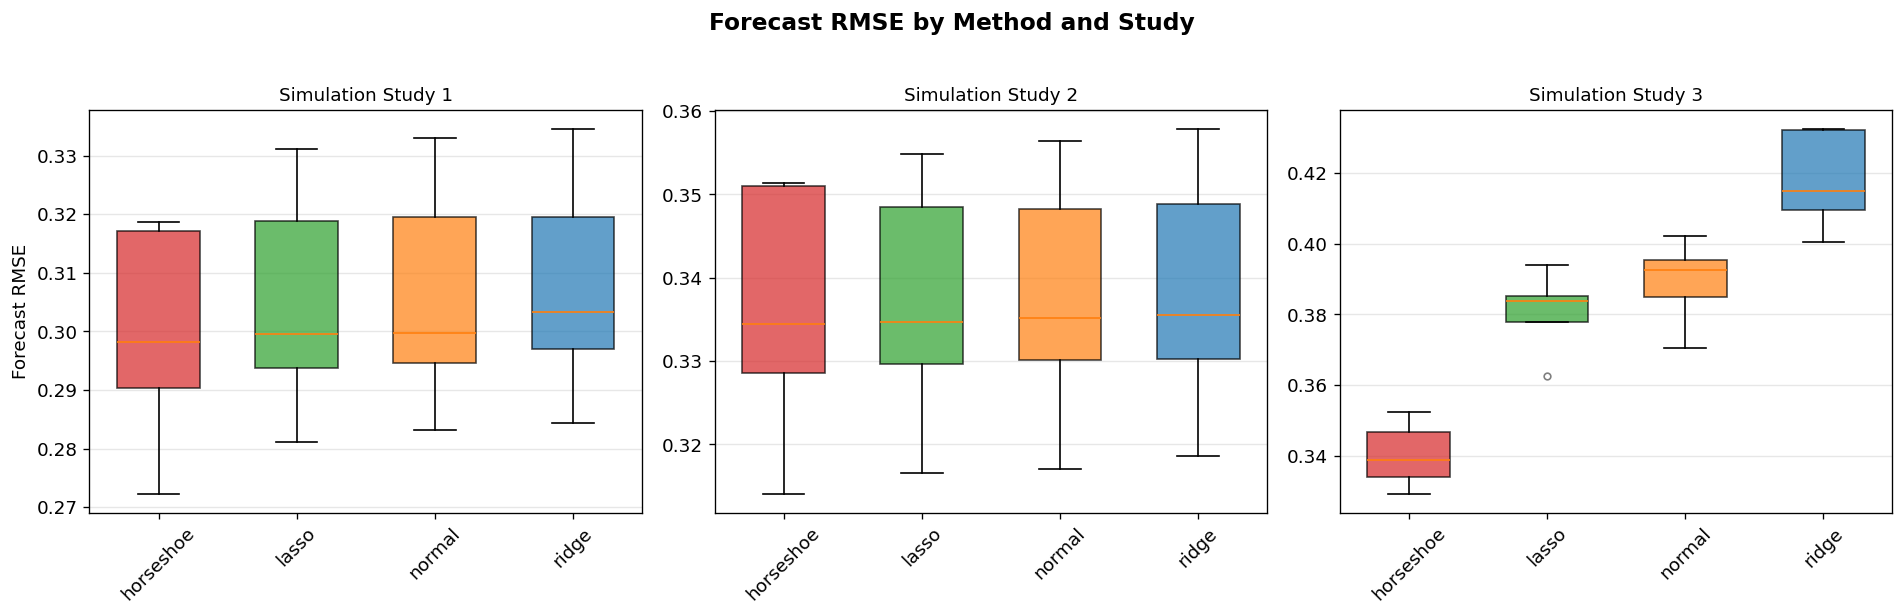

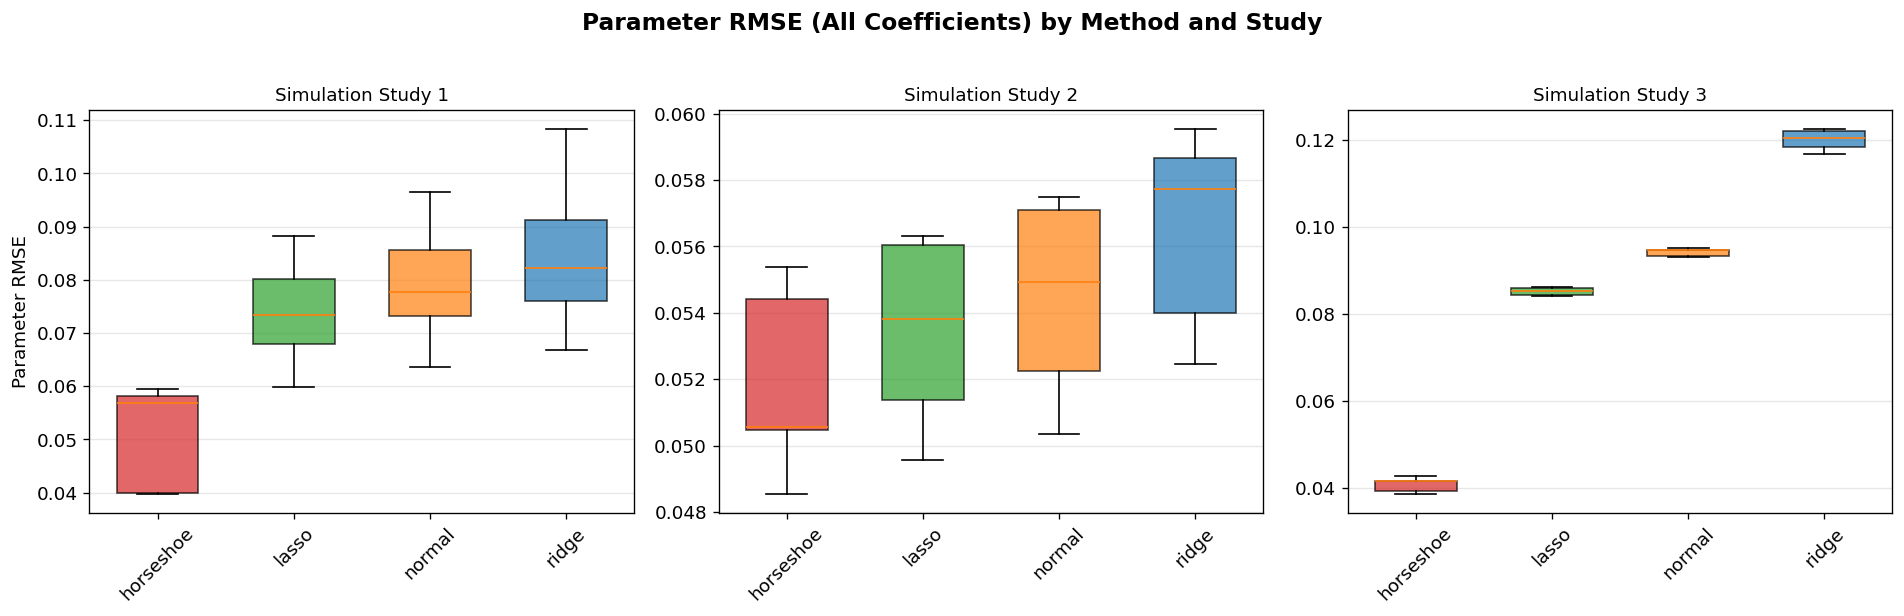

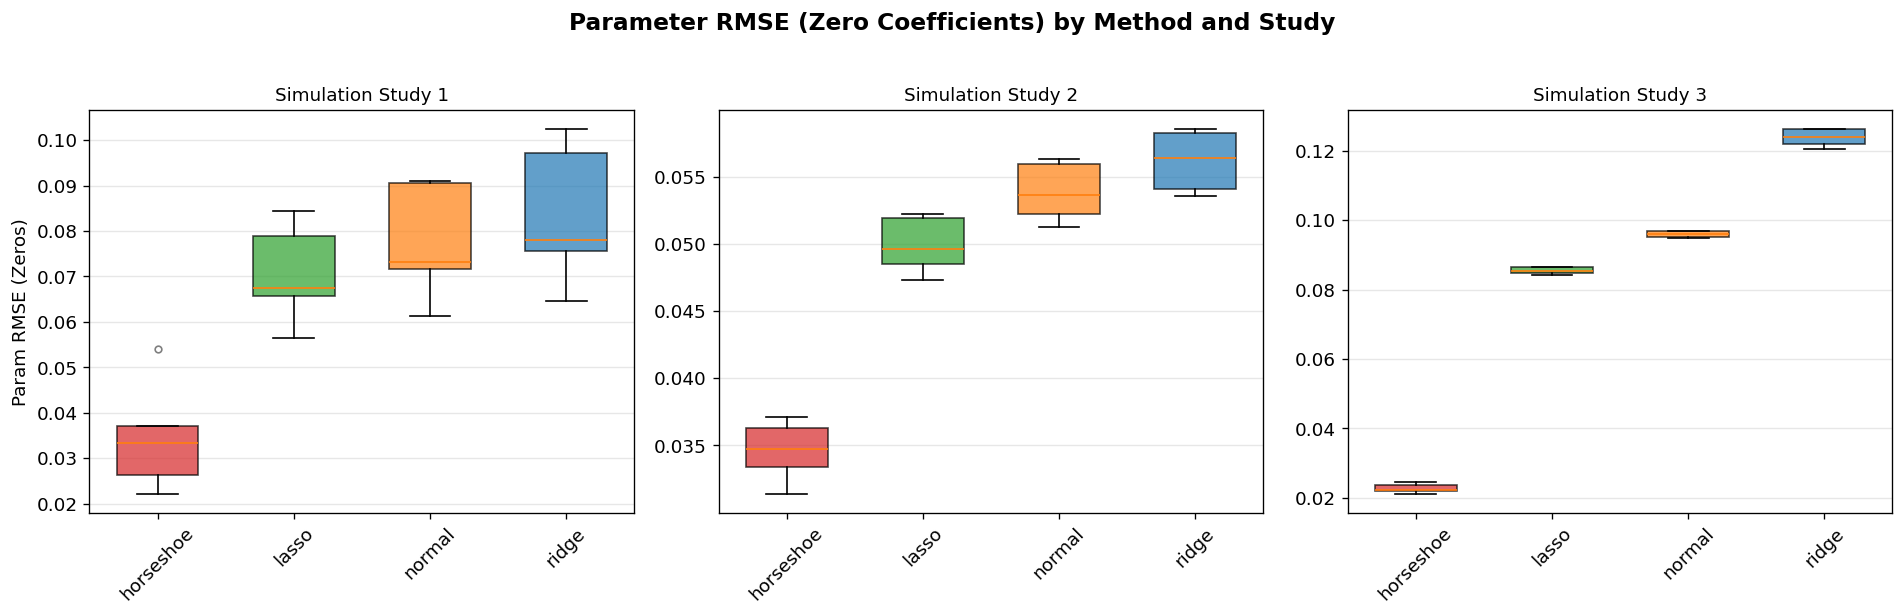

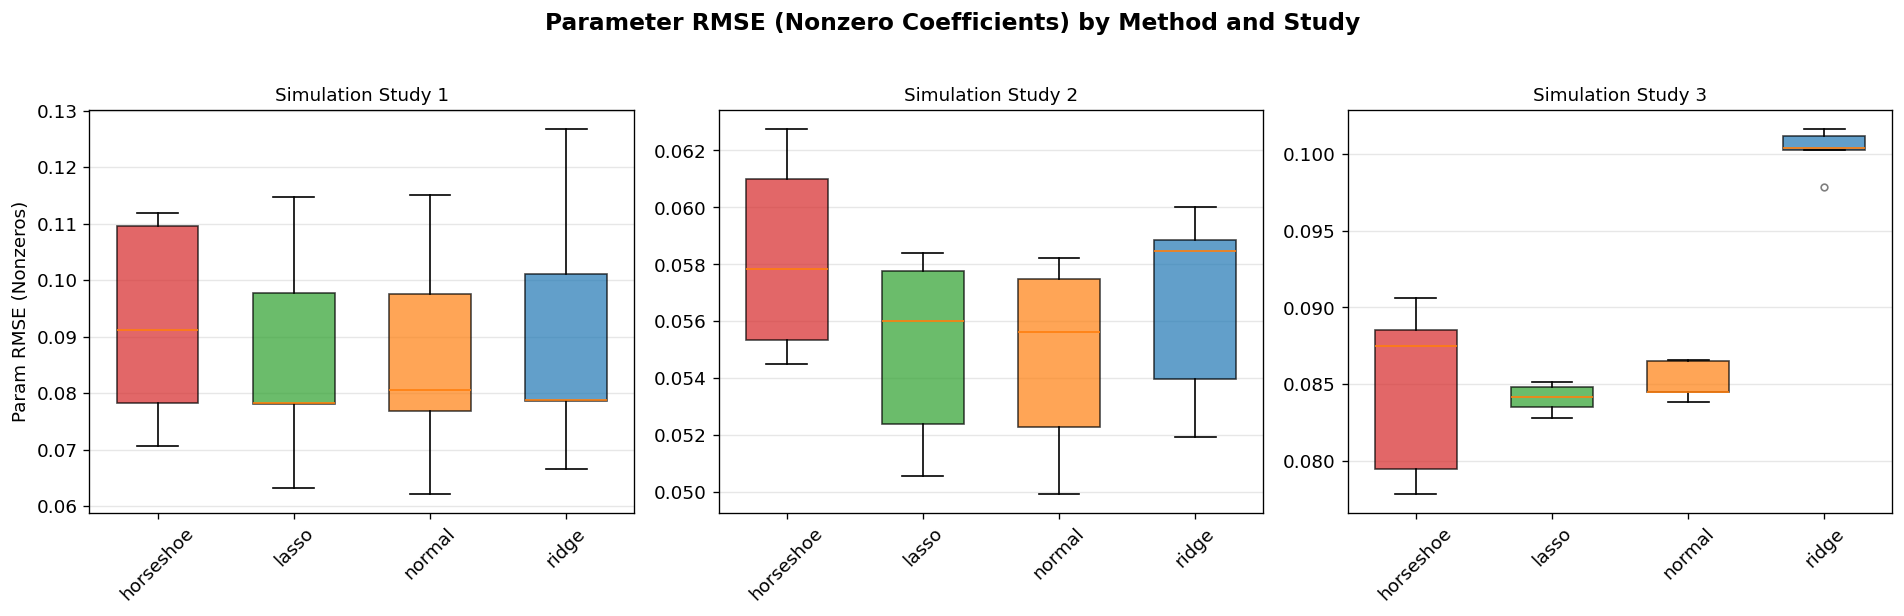

In [15]:
# ============================================================
# Section 7.1 — Forecast RMSE & Parameter RMSE Boxplots
# ============================================================
# R: ggplot(df_all, aes(x=method, y=forecast_rmse, fill=method))
#    + geom_boxplot() + facet_wrap(~scenario, scales="free_y")
# ============================================================

METHOD_PALETTE = {
    'ridge': '#1f77b4', 'normal': '#ff7f0e',
    'lasso': '#2ca02c', 'horseshoe': '#d62728',
}

def plot_boxplots(df, y_col, title, ylabel, figsize=(16, 5)):
    """Faceted boxplot by scenario — matches R ggplot pattern."""
    scenarios = df['scenario'].unique()
    n_sc = len(scenarios)
    fig, axes = plt.subplots(1, n_sc, figsize=figsize, sharey=False)
    if n_sc == 1:
        axes = [axes]
    
    for ax, sc in zip(axes, sorted(scenarios)):
        df_sc = df[df['scenario'] == sc]
        methods = sorted(df_sc['method'].unique())
        data = [df_sc[df_sc['method'] == m][y_col].dropna().values for m in methods]
        colors = [METHOD_PALETTE.get(m, '#888') for m in methods]
        
        bp = ax.boxplot(data, tick_labels=methods, patch_artist=True,
                       widths=0.6, showfliers=True,
                       flierprops=dict(marker='o', markersize=4, alpha=0.5))
        for patch, c in zip(bp['boxes'], colors):
            patch.set_facecolor(c)
            patch.set_alpha(0.7)
        
        ax.set_title(sc, fontsize=11)
        ax.set_ylabel(ylabel if ax == axes[0] else '')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# ── Forecast RMSE ────────────────────────────────────────────
plot_boxplots(df_all, 'forecast_rmse',
              'Forecast RMSE by Method and Study', 'Forecast RMSE')

# ── Parameter RMSE (All) ─────────────────────────────────────
plot_boxplots(df_all, 'param_rmse',
              'Parameter RMSE (All Coefficients) by Method and Study',
              'Parameter RMSE')

# ── Parameter RMSE (Zero Coefficients) ────────────────────────
plot_boxplots(df_all, 'param_rmse_zero',
              'Parameter RMSE (Zero Coefficients) by Method and Study',
              'Param RMSE (Zeros)')

# ── Parameter RMSE (Nonzero Coefficients) ────────────────────
plot_boxplots(df_all, 'param_rmse_nonzero',
              'Parameter RMSE (Nonzero Coefficients) by Method and Study',
              'Param RMSE (Nonzeros)')

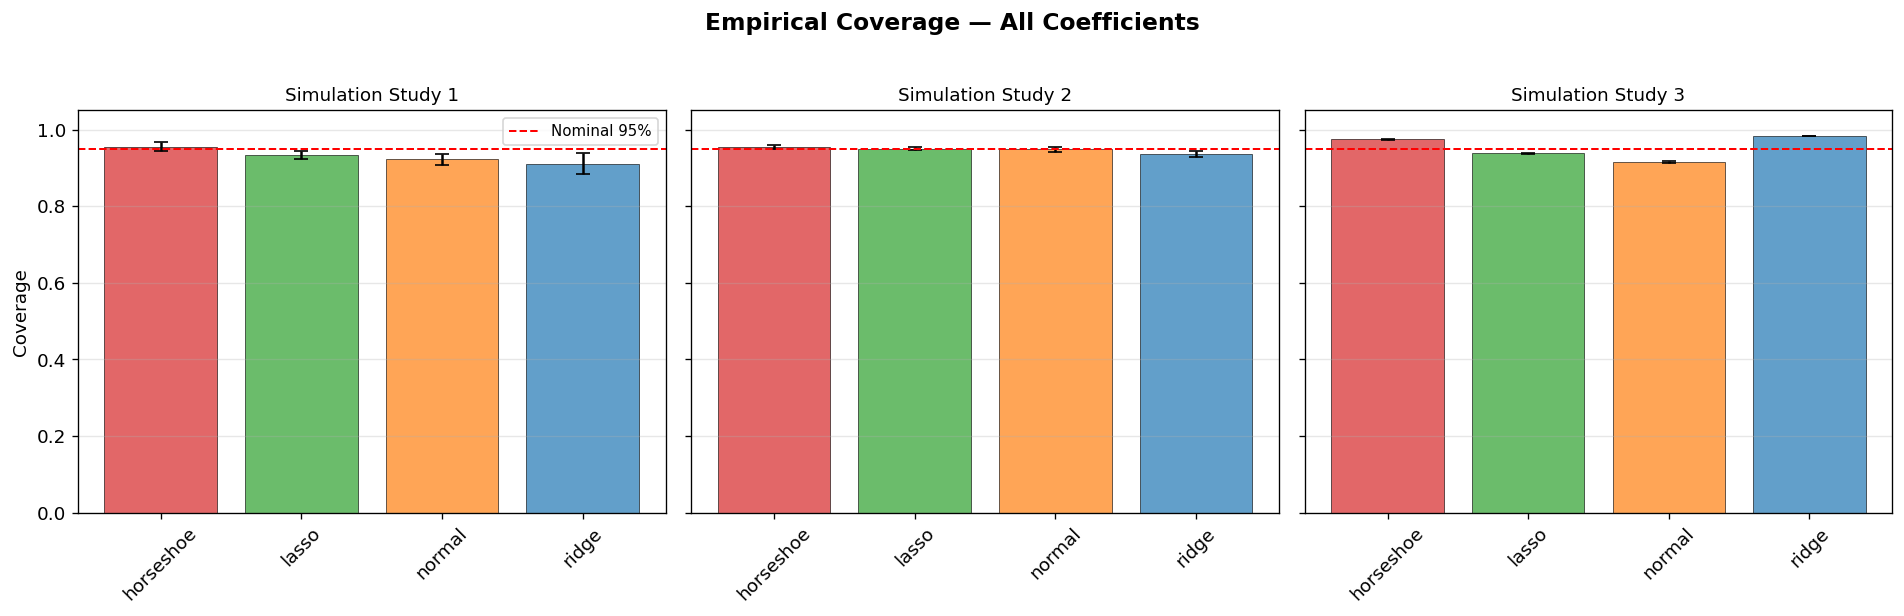

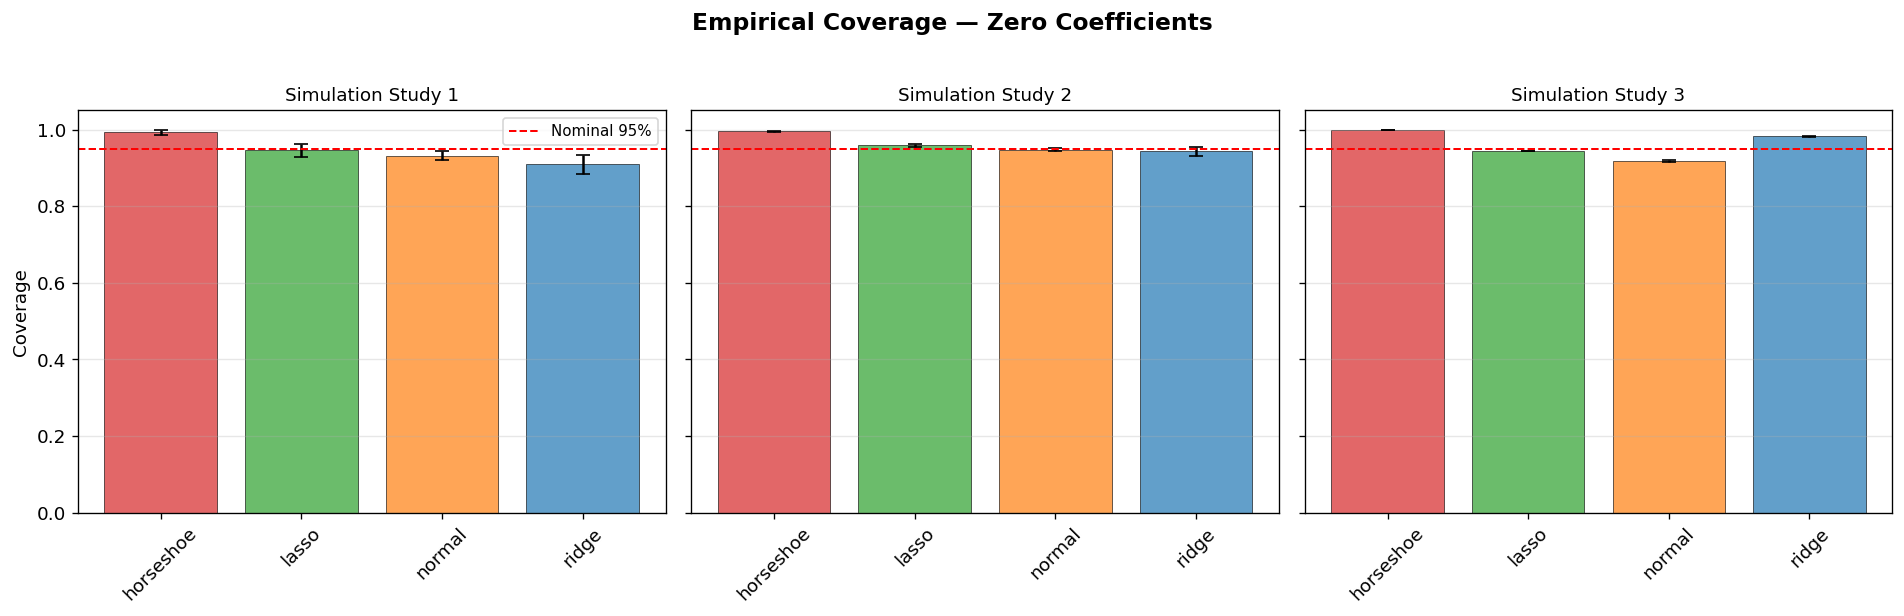

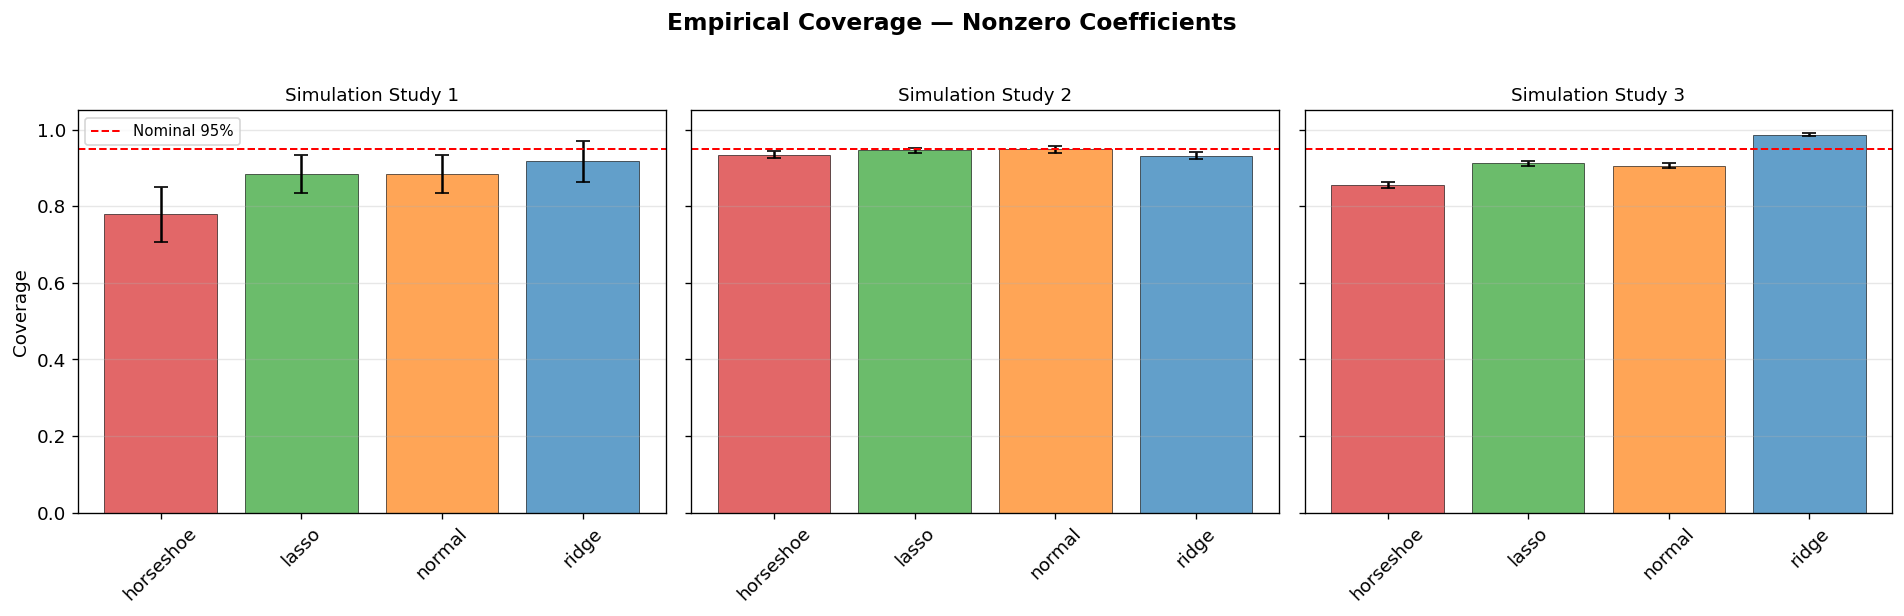

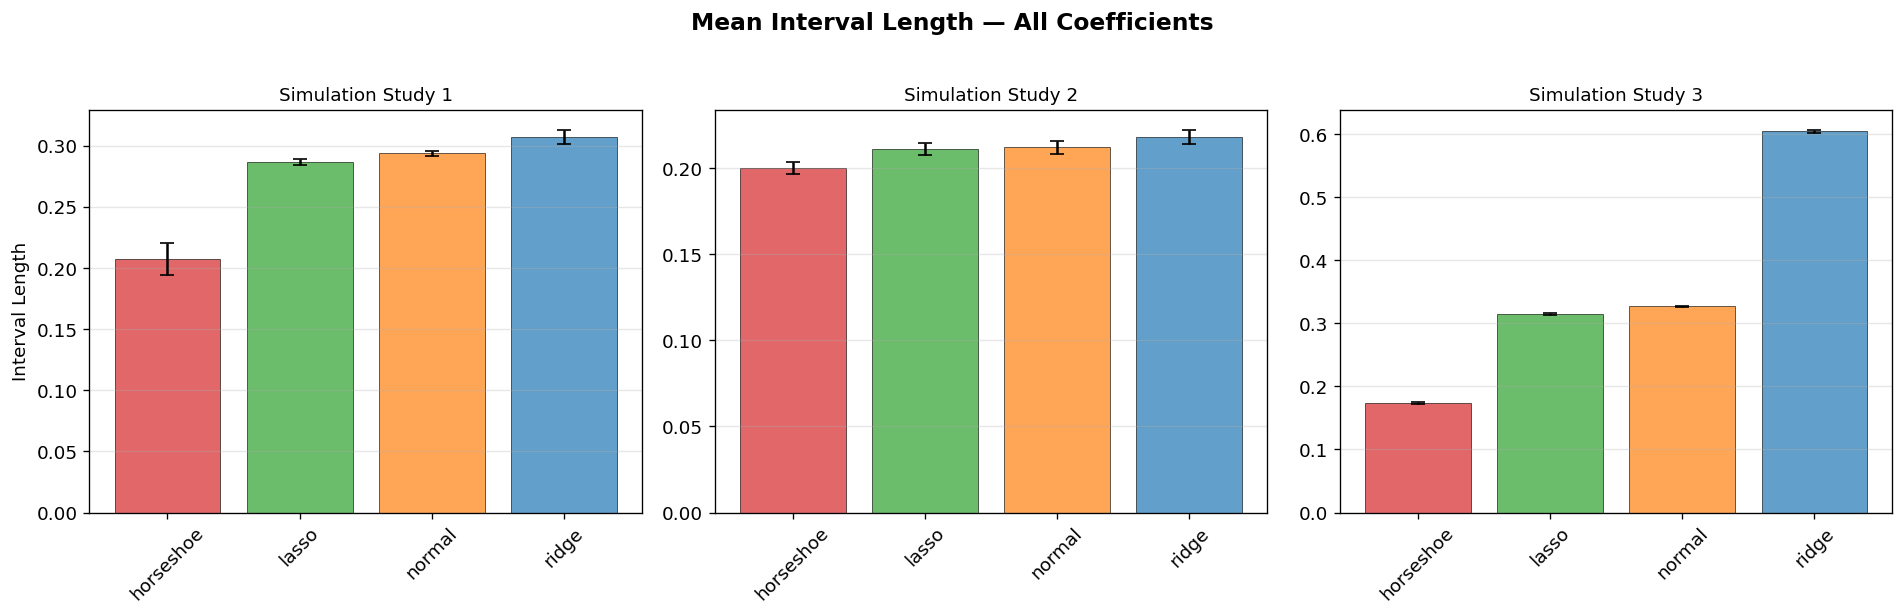

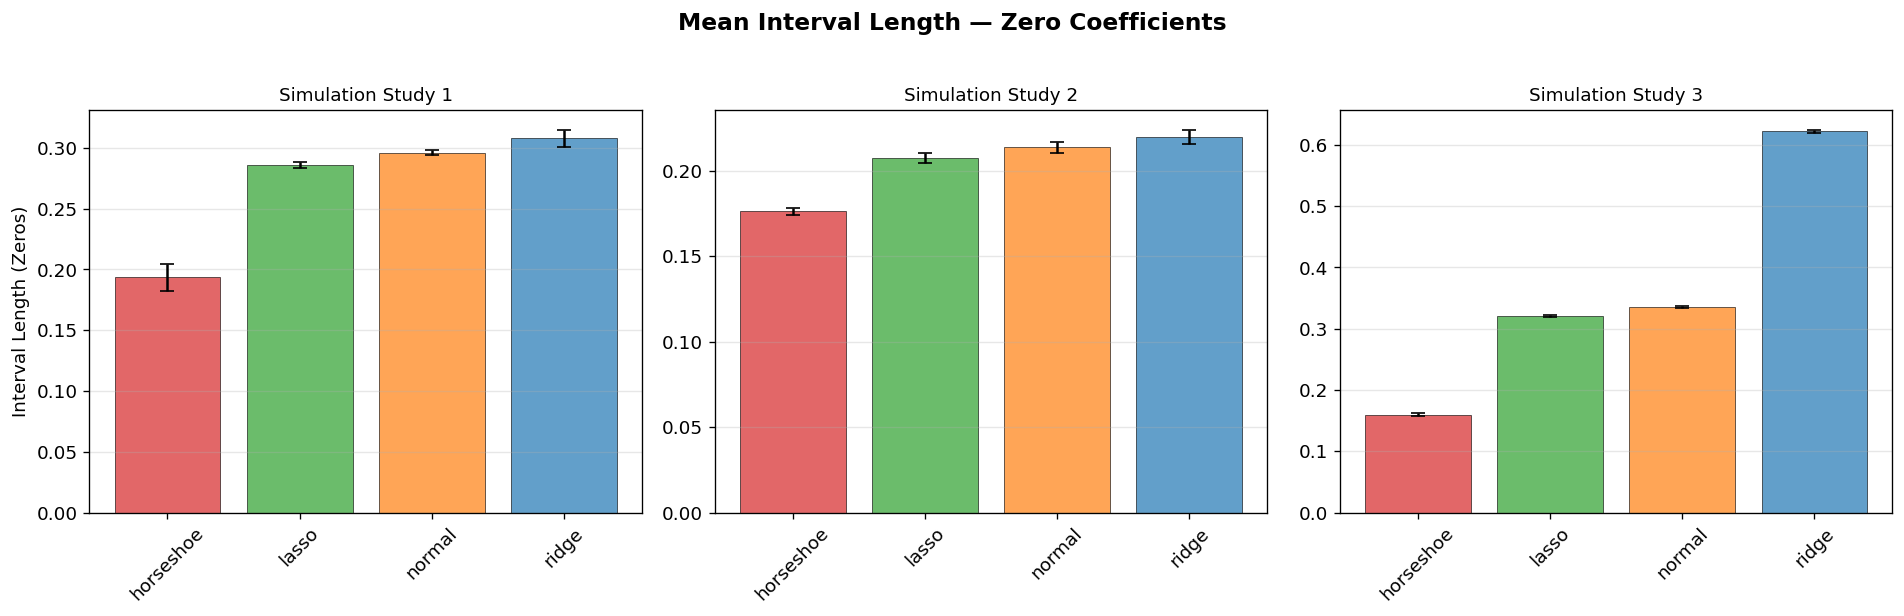

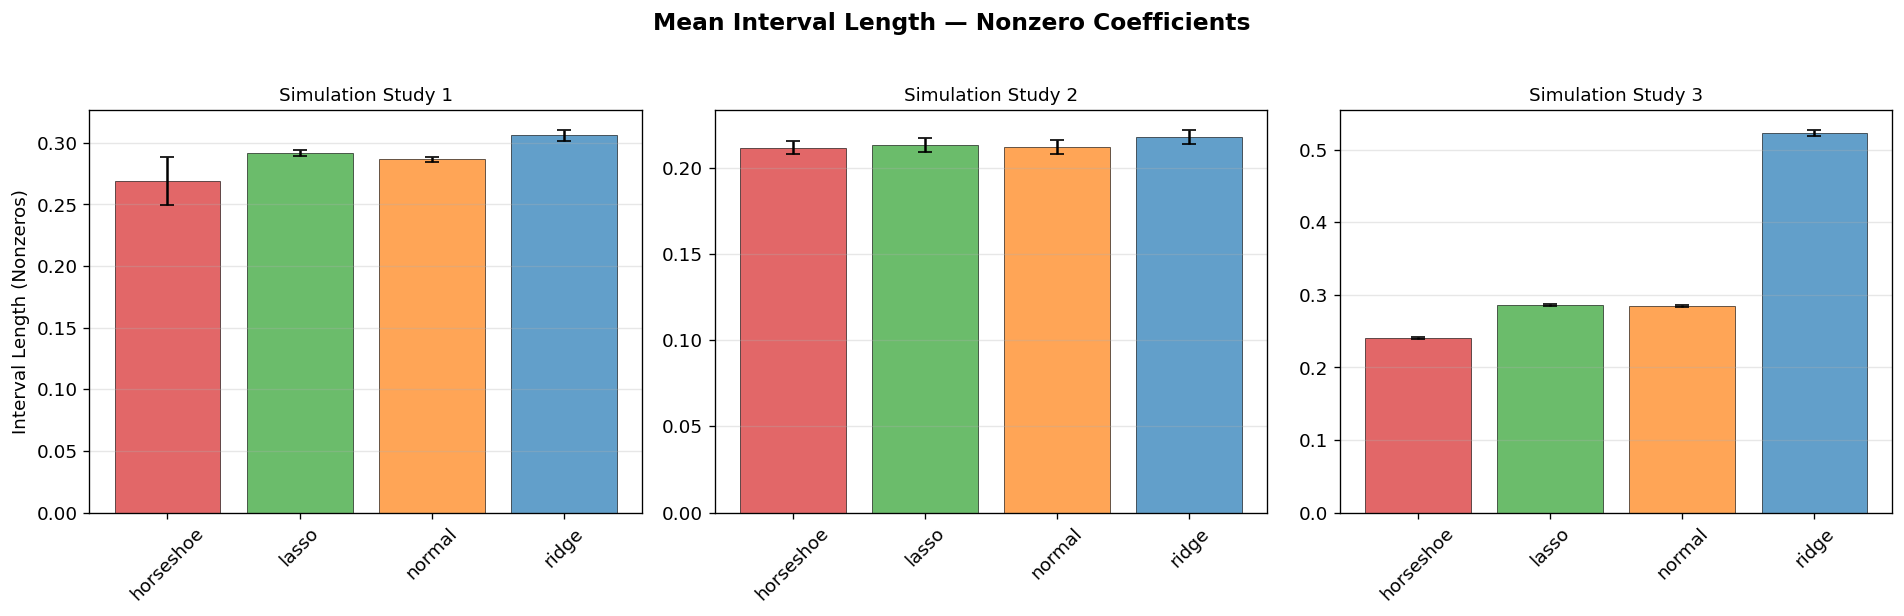

In [17]:
# ============================================================
# Section 7.2 — Coverage & Interval Length Bar Charts
# ============================================================
# R: coverage bar chart with horizontal line at 0.95

def plot_coverage_bars(df, cov_col, title, figsize=(16, 5)):
    """Bar chart of mean coverage ± SE, with 0.95 reference line."""
    scenarios = df['scenario'].unique()
    n_sc = len(scenarios)
    fig, axes = plt.subplots(1, n_sc, figsize=figsize, sharey=True)
    if n_sc == 1:
        axes = [axes]
    
    for ax, sc in zip(axes, sorted(scenarios)):
        df_sc = df[df['scenario'] == sc]
        methods = sorted(df_sc['method'].unique())
        means = [df_sc[df_sc['method'] == m][cov_col].mean() for m in methods]
        sems  = [df_sc[df_sc['method'] == m][cov_col].sem() for m in methods]
        colors = [METHOD_PALETTE.get(m, '#888') for m in methods]
        
        bars = ax.bar(methods, means, yerr=sems, capsize=4,
                      color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axhline(0.95, color='red', linestyle='--', linewidth=1.2, label='Nominal 95%')
        ax.set_ylim(0, 1.05)
        ax.set_title(sc, fontsize=11)
        ax.set_ylabel('Coverage' if ax == axes[0] else '')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
        if ax == axes[0]:
            ax.legend(fontsize=9)
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


def plot_interval_length_bars(df, il_col, title, ylabel, figsize=(16, 5)):
    """Bar chart of mean interval length ± SE."""
    scenarios = df['scenario'].unique()
    n_sc = len(scenarios)
    fig, axes = plt.subplots(1, n_sc, figsize=figsize, sharey=False)
    if n_sc == 1:
        axes = [axes]
    
    for ax, sc in zip(axes, sorted(scenarios)):
        df_sc = df[df['scenario'] == sc]
        methods = sorted(df_sc['method'].unique())
        means = [df_sc[df_sc['method'] == m][il_col].mean() for m in methods]
        sems  = [df_sc[df_sc['method'] == m][il_col].sem() for m in methods]
        colors = [METHOD_PALETTE.get(m, '#888') for m in methods]
        
        ax.bar(methods, means, yerr=sems, capsize=4,
               color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.set_title(sc, fontsize=11)
        ax.set_ylabel(ylabel if ax == axes[0] else '')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='y', alpha=0.3)
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# ── Coverage plots ────────────────────────────────────────────
plot_coverage_bars(df_all, 'coverage',
                   'Empirical Coverage — All Coefficients')
plot_coverage_bars(df_all, 'coverage_zero',
                   'Empirical Coverage — Zero Coefficients')
plot_coverage_bars(df_all, 'coverage_nonzero',
                   'Empirical Coverage — Nonzero Coefficients')

# ── Interval length plots ─────────────────────────────────────
plot_interval_length_bars(df_all, 'int_length',
                          'Mean Interval Length — All Coefficients',
                          'Interval Length')
plot_interval_length_bars(df_all, 'int_length_zero',
                          'Mean Interval Length — Zero Coefficients',
                          'Interval Length (Zeros)')
plot_interval_length_bars(df_all, 'int_length_nonzero',
                          'Mean Interval Length — Nonzero Coefficients',
                          'Interval Length (Nonzeros)')

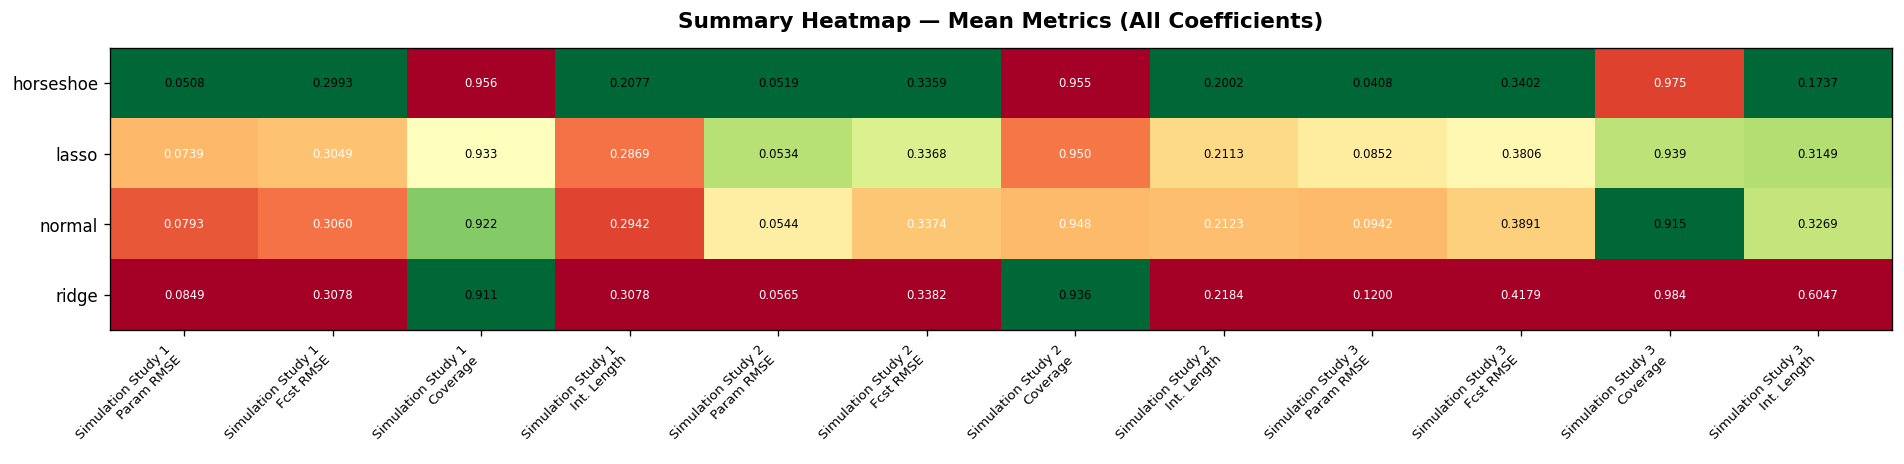


✅ Full results saved to d:\Bayesian Regresion\Lasso\var_sim_results\var_simulation_results.csv
   Shape: (60, 13)
   Scenarios: ['Simulation Study 1', 'Simulation Study 2', 'Simulation Study 3']
   Methods: ['ridge', 'normal', 'lasso', 'horseshoe']
   Replications per cell: [5]


In [18]:
# ============================================================
# Section 7.3 — Summary Heatmap & Final Ranking Table
# ============================================================

def plot_summary_heatmap(summary_all, summary_zero, summary_nonzero):
    """
    Heatmap of key metrics across scenarios × models.
    Rows = method, Columns = scenario×metric.
    """
    # Prepare data: pivot to method × (scenario, metric)
    metrics_to_show = ['mean_param_rmse', 'mean_forecast_rmse', 'mean_coverage', 'mean_int_length']
    metric_labels   = ['Param RMSE', 'Fcst RMSE', 'Coverage', 'Int. Length']
    
    scenarios = sorted(summary_all['scenario'].unique())
    methods   = sorted(summary_all['method'].unique())
    
    # Build matrix: rows = methods, cols = scenario × metric
    col_labels = []
    matrix = []
    
    for m in methods:
        row = []
        for sc in scenarios:
            sub = summary_all[(summary_all['method'] == m) & 
                              (summary_all['scenario'] == sc)]
            if len(sub) == 0:
                row.extend([np.nan] * len(metrics_to_show))
            else:
                for met in metrics_to_show:
                    row.append(sub[met].values[0] if met in sub.columns else np.nan)
        matrix.append(row)
    
    for sc in scenarios:
        for ml in metric_labels:
            col_labels.append(f'{sc}\n{ml}')
    
    matrix = np.array(matrix)
    
    fig, ax = plt.subplots(figsize=(max(16, len(col_labels)*1.2), 4))
    
    # Normalise each column for colour mapping
    with np.errstate(invalid='ignore'):
        col_min = np.nanmin(matrix, axis=0, keepdims=True)
        col_max = np.nanmax(matrix, axis=0, keepdims=True)
        col_range = col_max - col_min
        col_range[col_range == 0] = 1
        normed = (matrix - col_min) / col_range
    
    im = ax.imshow(normed, aspect='auto', cmap='RdYlGn_r')
    
    ax.set_xticks(range(len(col_labels)))
    ax.set_xticklabels(col_labels, fontsize=8, rotation=45, ha='right')
    ax.set_yticks(range(len(methods)))
    ax.set_yticklabels(methods, fontsize=10)
    
    # Annotate with actual values
    for i in range(len(methods)):
        for j in range(len(col_labels)):
            val = matrix[i, j]
            if np.isnan(val):
                txt = '—'
            elif 'Coverage' in col_labels[j]:
                txt = f'{val:.3f}'
            else:
                txt = f'{val:.4f}'
            ax.text(j, i, txt, ha='center', va='center', fontsize=7,
                    color='white' if normed[i, j] > 0.65 else 'black')
    
    ax.set_title('Summary Heatmap — Mean Metrics (All Coefficients)',
                 fontsize=13, fontweight='bold', pad=12)
    plt.tight_layout()
    plt.show()


# Run aggregation and plot
agg2 = aggregate_results(df_all)
plot_summary_heatmap(agg2['summary_all'], agg2['summary_zero'], agg2['summary_nonzero'])

# ── Save final dataframe ──────────────────────────────────────
out_csv = os.path.join(OUTPUT_DIR, 'var_simulation_results.csv')
df_all.to_csv(out_csv, index=False)
print(f"\n✅ Full results saved to {out_csv}")
print(f"   Shape: {df_all.shape}")
print(f"   Scenarios: {df_all['scenario'].unique().tolist()}")
print(f"   Methods: {df_all['method'].unique().tolist()}")
print(f"   Replications per cell: {df_all.groupby(['scenario','method']).size().unique().tolist()}")